# M4 | Research Investigation Notebook

In this notebook, you will do a research investigation of your chosen dataset in teams. You will begin by formally selecting your research question (task 0), then processing your data (task 1), creating a predictive model (task 2), evaluating your model's results (task 3), and describing the contributions of each team member (task 4).

For grading, please make sure your notebook has all cells already run. You will also need to write a short, 2 page report about your design decisions as a team, to be uploaded to Moodle in the form of a PDF file next to this Jupyter notebook.

You should provide arguments and justifications for all of your design decisions throughout this investigation. You can use your M3 responses as the basis for this discussion.

In [1]:
%load_ext autoreload
%autoreload 2

In [85]:
# Import the tables of the data set as dataframes.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import HDBSCAN
from sklearn.cluster import KMeans

from utils.clustering_eval_utils import evaluate_model
from utils.clustering import *

DATA_DIR = './data/Lernnavi' # You many change the directory

# Your code goes here

## Task 0: Research Question

**Research question:**
What distinct learning behaviors exist based on platform interactions and patterns over time? Can we categorize students into different learner types?

## Task 1: Data Preprocessing

In this section, you are asked to preprocess your data in a way that is relevant for the model. Please include 1-2 visualizations of features / data explorations that are related to your downstream prediction task.

# 1. Load Data


In [3]:
users = pd.read_csv('{}/users.csv.gz'.format(DATA_DIR))
events = pd.read_csv('{}/events.csv.gz'.format(DATA_DIR))
transactions = pd.read_csv('{}/transactions.csv.gz'.format(DATA_DIR))

In [4]:
users.columns

Index(['user_id', 'gender', 'canton', 'class_level', 'study', 'class_id'], dtype='object')

In [5]:
events.columns

Index(['event_id', 'user_id', 'event_date', 'category', 'action', 'event_type',
       'transaction_token', 'tracking_data', 'session_id', 'topic_id',
       'session_closed', 'session_type', 'session_accepted'],
      dtype='object')

In [6]:
transactions.columns

Index(['transaction_id', 'transaction_token', 'user_id', 'document_id',
       'document_version', 'evaluation', 'input', 'start_time', 'commit_time',
       'user_agent', 'solution', 'type', 'session_id', 'topic_id',
       'session_closed', 'session_type', 'session_accepted', 'challenge',
       'challenge_id', 'challenge_order', 'challenge_name'],
      dtype='object')

# 2. Feature Engineering


## 2.1 Session-based Features
- Standard deviation of session duration
- Median session duration

### Step 1 — Session-level features

In [7]:
# Example for session features
df_events = events.copy()
df_events['event_date'] = pd.to_datetime(df_events['event_date'])
#date


In [8]:
session_features = df_events.groupby(['user_id', 'session_id']).agg(
    num_events_in_session=('event_date', 'count'),
    session_duration_min=('event_date', lambda x: (x.max() - x.min()).total_seconds() / 60),
    session_closed=('session_closed', 'max'),  # should be 0 or 1
    session_accepted=('session_accepted', 'max'),
    unique_topics_in_session=('topic_id', 'nunique')
).reset_index()


### Step 2 — User-level aggregations from session_features

In [9]:
user_session_features = session_features.groupby('user_id').agg(
    total_sessions=('session_id', 'nunique'),
    total_num_events=('num_events_in_session', 'sum'),
    avg_session_duration_min=('session_duration_min', 'mean'),
    median_session_duration_min=('session_duration_min', 'median'),
    std_session_duration_min=('session_duration_min', 'std'),
    max_session_duration_min=('session_duration_min', 'max'),
    min_session_duration_min=('session_duration_min', 'min'),
    avg_num_events_per_session=('num_events_in_session', 'mean'),
    avg_unique_topics_per_session=('unique_topics_in_session', 'mean'),
    pct_sessions_closed=('session_closed', 'mean'),
    pct_sessions_accepted=('session_accepted', 'mean')
).reset_index()


### Step 3 — Time between sessions


In [10]:
# Sort by user and session start
session_features = session_features.sort_values(['user_id', 'session_id'])  # we need to know time order
df_events['event_date'] = pd.to_datetime(df_events['event_date'])

# Calculate session start date
session_starts = df_events.groupby(['user_id', 'session_id'])['event_date'].min().reset_index()
session_starts = session_starts.sort_values(['user_id', 'event_date'])

# Calculate time differences
session_starts['time_since_last_session_hr'] = session_starts.groupby('user_id')['event_date'].diff().dt.total_seconds() / 3600

# Aggregate per user
temporal_features = session_starts.groupby('user_id').agg(
    avg_time_between_sessions_hr=('time_since_last_session_hr', 'mean'),
    std_time_between_sessions_hr=('time_since_last_session_hr', 'std'),
    max_inactivity_period_hr=('time_since_last_session_hr', 'max')
).reset_index()


### Step 4 — Active days & average sessions per active day

In [11]:
df_events['event_date_only'] = df_events['event_date'].dt.date
days_active = df_events.groupby('user_id')['event_date_only'].nunique().reset_index(name='days_active')

# Sessions per day
sessions_per_day = session_starts.copy()
sessions_per_day['session_day'] = sessions_per_day['event_date'].dt.date
sessions_per_day = sessions_per_day.groupby(['user_id', 'session_day']).size().reset_index(name='sessions_per_day')
avg_sessions_per_active_day = sessions_per_day.groupby('user_id')['sessions_per_day'].mean().reset_index(name='avg_sessions_per_active_day')


### Step 5 — Final merge: Session Features

In [12]:
final_session_features = user_session_features \
    .merge(temporal_features, on='user_id', how='left') \
    .merge(days_active, on='user_id', how='left') \
    .merge(avg_sessions_per_active_day, on='user_id', how='left')


In [13]:
final_session_features

,user_id,total_sessions,total_num_events,avg_session_duration_min,median_session_duration_min,std_session_duration_min,max_session_duration_min,min_session_duration_min,avg_num_events_per_session,avg_unique_topics_per_session,pct_sessions_closed,pct_sessions_accepted,avg_time_between_sessions_hr,std_time_between_sessions_hr,max_inactivity_period_hr,days_active,avg_sessions_per_active_day
0,387604,61,1105,12963.096278,1.331083,64843.133625,492921.146800,0.000000,18.114754,0.918033,0.982143,0.826087,229.595889,425.555724,1676.341603,100,2.103448
1,387605,67,742,29595.661530,3.315933,98793.615011,531286.253133,0.000000,11.074627,0.955224,0.984375,1.000000,187.273808,464.944778,3120.276084,54,2.913043
2,387608,31,469,11904.947317,3.627667,40661.940478,217246.262683,0.000000,15.129032,0.548387,1.000000,1.000000,407.203174,787.446374,3049.412006,87,2.214286
3,387613,4,31,1.019733,0.923208,0.581060,1.766600,0.465917,7.750000,1.000000,0.750000,1.000000,439.497068,548.218223,1053.816563,5,1.333333
4,387615,2,48,9.675450,9.675450,0.642996,10.130117,9.220783,24.000000,1.000000,1.000000,1.000000,0.172846,NaN,0.172846,12,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19625,431999,4,21,4.107954,2.271158,4.881144,11.189883,0.699617,5.250000,1.000000,0.750000,NaN,0.084585,0.091561,0.190299,1,4.000000
19626,432001,1,7,13.184783,13.184783,NaN,13.184783,13.184783,7.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,1,1.000000
19627,432014,2,25,7.975892,7.975892,4.141560,10.904417,5.047367,12.500000,1.000000,1.000000,1.000000,0.092280,NaN,0.092280,1,2.000000
19628,432016,2,4,0.564775,0.564775,0.644304,1.020367,0.109183,2.000000,1.000000,0.500000,NaN,0.006462,NaN,0.006462,1,2.000000


In [14]:
# Step 1: Fill standard deviation and time-based NaNs with 0
std_cols = ['std_time_between_sessions_hr', 'std_session_duration_min']
time_cols = ['avg_time_between_sessions_hr', 'max_inactivity_period_hr']

final_session_features[std_cols + time_cols] = final_session_features[std_cols + time_cols].fillna(0)

# Step 2: Fill acceptance ratio with 0 (means no acceptance events)
final_session_features['pct_sessions_accepted'] = final_session_features['pct_sessions_accepted'].fillna(0)

# Step 3: Fill pct_sessions_closed with median (only 3 missing values)
final_session_features['pct_sessions_closed'] = final_session_features['pct_sessions_closed'].fillna(final_session_features['pct_sessions_closed'].median())

# Step 4: Double check
print(final_session_features.isnull().sum())


user_id                          0
total_sessions                   0
total_num_events                 0
avg_session_duration_min         0
median_session_duration_min      0
std_session_duration_min         0
max_session_duration_min         0
min_session_duration_min         0
avg_num_events_per_session       0
avg_unique_topics_per_session    0
pct_sessions_closed              0
pct_sessions_accepted            0
avg_time_between_sessions_hr     0
std_time_between_sessions_hr     0
max_inactivity_period_hr         0
days_active                      0
avg_sessions_per_active_day      0
dtype: int64


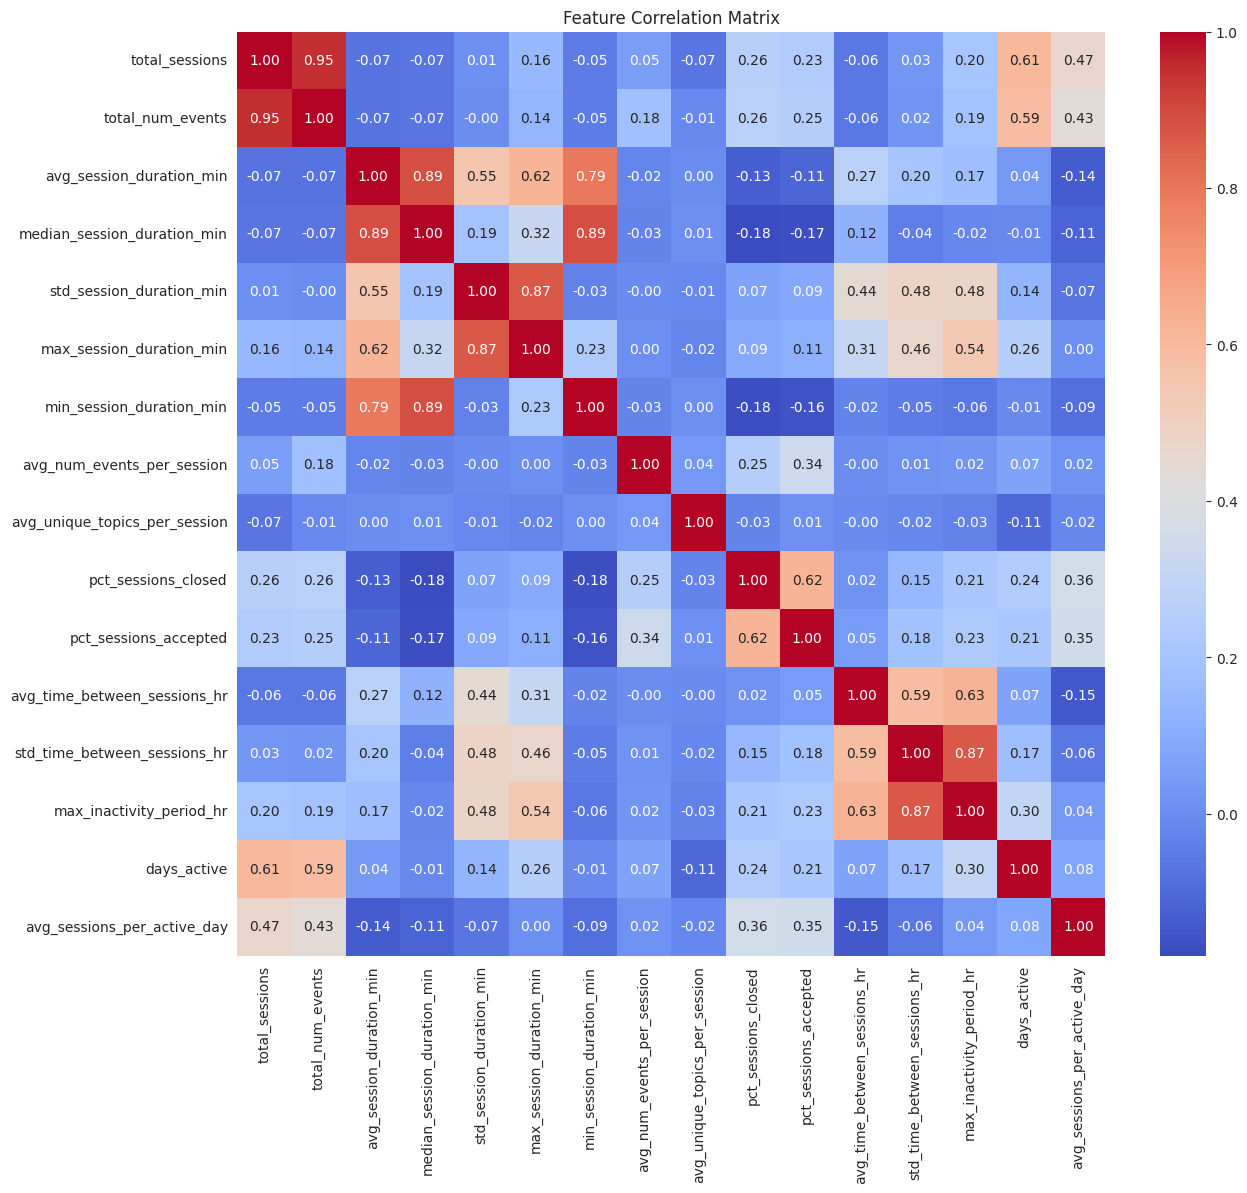

In [15]:
# Drop user_id (keep it somewhere safe if you need to track students later)
X = final_session_features.drop(columns=['user_id'])

import matplotlib.pyplot as plt
import seaborn as sns

# Correlation matrix
plt.figure(figsize=(14,12))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.show()



## Correlation Analysis of Session-Based Features

To ensure we avoid redundancy in the feature space and maintain meaningful dimensions for clustering, we performed a correlation analysis on the session-based features.

Key observations:
- **total_sessions** and **total_num_events** were highly correlated (0.95). We decided to keep **total_sessions** (more interpretable) and drop **total_num_events**.
- **median_session_duration_min** and **max_session_duration_min** were highly correlated (0.89). We kept **median_session_duration_min** (more robust to outliers).
- **avg_time_between_sessions_hr** and **max_inactivity_period_hr** were also highly correlated (0.86). We chose to retain **avg_time_between_sessions_hr** to better capture regularity.

Other features showed moderate or low correlation and were retained to preserve richness in behavioral descriptions.

After pruning, we kept a diverse, minimally redundant set of features. Scaling will be applied next before moving to dimensionality reduction and clustering.


In [16]:
# 1. Drop user_id to work only with features
X = final_session_features.drop(columns=['user_id'])

# 2. Drop highly correlated features
X = X.drop(columns=[
    'total_num_events',          # because of high correlation with total_sessions
    'max_session_duration_min',  # because of high correlation with median session duration
    'max_inactivity_period_hr'    # because of high correlation with avg_time_between_sessions
])

# Optional: keep or drop std_session_duration_min if you want a stricter pruning (we keep it for now)

# 3. Attach back user_id if needed (optional, useful to track students after clustering)
final_session_features_clean = pd.concat([final_session_features[['user_id']], X], axis=1)

# 4. Quick check
final_session_features_clean.head()


,user_id,total_sessions,avg_session_duration_min,median_session_duration_min,std_session_duration_min,min_session_duration_min,avg_num_events_per_session,avg_unique_topics_per_session,pct_sessions_closed,pct_sessions_accepted,avg_time_between_sessions_hr,std_time_between_sessions_hr,days_active,avg_sessions_per_active_day
0,387604,61,12963.096278,1.331083,64843.133625,0.000000,18.114754,0.918033,0.982143,0.826087,229.595889,425.555724,100,2.103448
1,387605,67,29595.661530,3.315933,98793.615011,0.000000,11.074627,0.955224,0.984375,1.000000,187.273808,464.944778,54,2.913043
2,387608,31,11904.947317,3.627667,40661.940478,0.000000,15.129032,0.548387,1.000000,1.000000,407.203174,787.446374,87,2.214286
3,387613,4,1.019733,0.923208,0.581060,0.465917,7.750000,1.000000,0.750000,1.000000,439.497068,548.218223,5,1.333333
4,387615,2,9.675450,9.675450,0.642996,9.220783,24.000000,1.000000,1.000000,1.000000,0.172846,0.000000,12,2.000000


In [17]:
final_session_features.columns

Index(['user_id', 'total_sessions', 'total_num_events',
       'avg_session_duration_min', 'median_session_duration_min',
       'std_session_duration_min', 'max_session_duration_min',
       'min_session_duration_min', 'avg_num_events_per_session',
       'avg_unique_topics_per_session', 'pct_sessions_closed',
       'pct_sessions_accepted', 'avg_time_between_sessions_hr',
       'std_time_between_sessions_hr', 'max_inactivity_period_hr',
       'days_active', 'avg_sessions_per_active_day'],
      dtype='object')

## 2.2 Performance-based Features
- Progression trend (e.g., did scores improve?)
- Ratio of correct/incorrect responses

### Step 1 — Accuracy by Question Type

In [18]:
df_transactions = transactions.copy()

In [19]:
# 1. Check if evaluation exists
print('evaluation' in df_transactions.columns)

# 2. Check if type exists
print('type' in df_transactions.columns)

# 3. See a sample of your transactions
df_transactions.head()

# 4. Check if evaluation values are NaN
print(df_transactions['evaluation'].isnull().mean())

# 5. Check if type values are NaN
print(df_transactions['type'].isnull().mean())


True
True
0.34371655067386997
0.34347062127387684


## Note on Accuracy by Question Type

Initially, we intended to compute user accuracy per question type based on the `evaluation` field from the transactions table.

However, upon inspection, we found that the `evaluation` column is entirely missing (100% NaN) in the provided dataset.  
As a result, it is not possible to derive meaningful accuracy measures for users.

Therefore, we decided to exclude the "Accuracy by Question Type" feature from our performance feature set and focus on alternative behavioral indicators, such as response times, task diversity, and topic diversity.


### Step 2 — Median Response Time by Question Type

In [20]:
# Compute response time
df_transactions['start_time'] = pd.to_datetime(df_transactions['start_time'])
df_transactions['commit_time'] = pd.to_datetime(df_transactions['commit_time'])

df_transactions['response_time_sec'] = (df_transactions['commit_time'] - df_transactions['start_time']).dt.total_seconds()

# Median response time per user and question type
median_response_time = df_transactions.groupby(['user_id', 'type'])['response_time_sec'].median().unstack()

# Check
median_response_time.head()


type,CLOZE_MATH,CLOZE_TEXT,CLOZE_TEXT_DROPDOWN,DND_GROUP,DND_IN_TEXT,DND_ORDER,DND_PAIRS,FIX_TEXT,GRAPH_CLICK_POINTS,GRAPH_SELECT_SHAPE,GRAPH_SOLUTION_FIELD,HIGHLIGHT,MATH_STEP_BY_STEP,MULTIPLE_CHOICE,MULTI_COLOR_HIGHLIGHT,OPEN_TASK,SEPARATE_TEXT,SOLUTION_FIELD
user_id,,,,,,,,,,,,,,,,,,
387604,NaN,19.5185,20.7750,11.2100,19.081,27.560,18.8735,19.9335,NaN,NaN,NaN,36.010,NaN,14.7965,30.144,26.138,15.2045,NaN
387605,32.646,24.7470,15.7585,57.8570,27.930,19.688,31.7535,35.0460,74.3065,11.921,107.6295,95.275,69.994,15.1780,44.618,18.241,8.1910,32.6680
387608,27.009,NaN,13.3600,55.5665,NaN,30.129,29.1065,NaN,8.3795,14.589,NaN,NaN,61.063,19.5045,NaN,NaN,NaN,19.0135
387613,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.331,NaN,NaN,NaN,NaN,20.9145
387615,NaN,NaN,51.6140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.7200,NaN,NaN,14.6040,NaN


In [21]:
# Drop users with all NaNs in response time
median_response_time_clean = median_response_time.dropna(how='all')
median_response_time_clean = median_response_time_clean.fillna(0)

# Check
print(f"Remaining users: {len(median_response_time_clean)} / {len(median_response_time)}")
median_response_time_clean.head()


Remaining users: 21434 / 21434


type,CLOZE_MATH,CLOZE_TEXT,CLOZE_TEXT_DROPDOWN,DND_GROUP,DND_IN_TEXT,DND_ORDER,DND_PAIRS,FIX_TEXT,GRAPH_CLICK_POINTS,GRAPH_SELECT_SHAPE,GRAPH_SOLUTION_FIELD,HIGHLIGHT,MATH_STEP_BY_STEP,MULTIPLE_CHOICE,MULTI_COLOR_HIGHLIGHT,OPEN_TASK,SEPARATE_TEXT,SOLUTION_FIELD
user_id,,,,,,,,,,,,,,,,,,
387604,0.000,19.5185,20.7750,11.2100,19.081,27.560,18.8735,19.9335,0.0000,0.000,0.0000,36.010,0.000,14.7965,30.144,26.138,15.2045,0.0000
387605,32.646,24.7470,15.7585,57.8570,27.930,19.688,31.7535,35.0460,74.3065,11.921,107.6295,95.275,69.994,15.1780,44.618,18.241,8.1910,32.6680
387608,27.009,0.0000,13.3600,55.5665,0.000,30.129,29.1065,0.0000,8.3795,14.589,0.0000,0.000,61.063,19.5045,0.000,0.000,0.0000,19.0135
387613,0.000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,41.331,0.0000,0.000,0.000,0.0000,20.9145
387615,0.000,0.0000,51.6140,0.0000,0.000,0.000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.000,21.7200,0.000,0.000,14.6040,0.0000


- Students who did not attempt any tasks were removed from the dataset.

- For students who missed some task types, missing median response times were filled with 0, 
meaning "no recorded interaction" for that task type.

### Step 3 — Task Diversity

In [22]:
# Step 3: Task diversity
task_diversity = df_transactions.groupby('user_id')['type'].nunique().reset_index()
task_diversity.columns = ['user_id', 'task_type_diversity']

# Check
task_diversity.head()


,user_id,task_type_diversity
0,387604,12
1,387605,18
2,387608,10
3,387613,2
4,387615,3


### Step 4 — Preferred Task Type

In [23]:
# Step 3B: Preferred task type
def safe_mode(series):
    mode = series.mode()
    return mode.iloc[0] if not mode.empty else np.nan

preferred_task_type = df_transactions.groupby('user_id')['type'].agg(safe_mode).reset_index()
preferred_task_type.columns = ['user_id', 'preferred_task_type']

# Check
preferred_task_type.head()


,user_id,preferred_task_type
0,387604,CLOZE_TEXT_DROPDOWN
1,387605,SOLUTION_FIELD
2,387608,MULTIPLE_CHOICE
3,387613,MATH_STEP_BY_STEP
4,387615,MULTIPLE_CHOICE


### Step 5 — Topic Diversity

In [24]:
# Step 3C: Topic diversity
topic_diversity = df_events.groupby('user_id')['topic_id'].nunique().reset_index()
topic_diversity.columns = ['user_id', 'topic_diversity']

# Check
topic_diversity.head()


,user_id,topic_diversity
0,387604,14
1,387605,27
2,387608,12
3,387613,4
4,387615,1


### Step 6 - Clean merging of all performance features

In [25]:
# --- 1. Clean median_response_time ---
# Drop users with all NaN
median_response_time_clean = median_response_time.dropna(how='all')

# Fill missing response times with 0
median_response_time_clean = median_response_time_clean.fillna(0)

# Ensure user_id is a column
median_response_time_clean['user_id'] = median_response_time_clean.index
median_response_time_clean = median_response_time_clean.reset_index(drop=True)

# --- 2. Merge all performance features ---
performance_features = median_response_time_clean.merge(task_diversity, on='user_id', how='left')
performance_features = performance_features.merge(preferred_task_type, on='user_id', how='left')
performance_features = performance_features.merge(topic_diversity, on='user_id', how='left')

# --- 3. Check the result ---
print(f"Shape of performance_features: {performance_features.shape}")
performance_features.head()


Shape of performance_features: (21434, 22)


,CLOZE_MATH,CLOZE_TEXT,CLOZE_TEXT_DROPDOWN,DND_GROUP,DND_IN_TEXT,DND_ORDER,DND_PAIRS,FIX_TEXT,GRAPH_CLICK_POINTS,GRAPH_SELECT_SHAPE,...,MATH_STEP_BY_STEP,MULTIPLE_CHOICE,MULTI_COLOR_HIGHLIGHT,OPEN_TASK,SEPARATE_TEXT,SOLUTION_FIELD,user_id,task_type_diversity,preferred_task_type,topic_diversity
0,0.000,19.5185,20.7750,11.2100,19.081,27.560,18.8735,19.9335,0.0000,0.000,...,0.000,14.7965,30.144,26.138,15.2045,0.0000,387604,12,CLOZE_TEXT_DROPDOWN,14
1,32.646,24.7470,15.7585,57.8570,27.930,19.688,31.7535,35.0460,74.3065,11.921,...,69.994,15.1780,44.618,18.241,8.1910,32.6680,387605,18,SOLUTION_FIELD,27
2,27.009,0.0000,13.3600,55.5665,0.000,30.129,29.1065,0.0000,8.3795,14.589,...,61.063,19.5045,0.000,0.000,0.0000,19.0135,387608,10,MULTIPLE_CHOICE,12
3,0.000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.0000,0.0000,0.000,...,41.331,0.0000,0.000,0.000,0.0000,20.9145,387613,2,MATH_STEP_BY_STEP,4
4,0.000,0.0000,51.6140,0.0000,0.000,0.000,0.0000,0.0000,0.0000,0.000,...,0.000,21.7200,0.000,0.000,14.6040,0.0000,387615,3,MULTIPLE_CHOICE,1


## Performance-Based Features Construction

We selected the following performance features:
- Median response time per question type
- Task type diversity (number of task types attempted)
- Preferred task type (most frequent task type)
- Topic diversity (number of unique topics worked on)

The features were merged into a single table for further cleaning and analysis.


In [26]:
# Check missing values
missing_report = performance_features.isnull().sum()

# Display columns with missing values
missing_report[missing_report > 0]


Series([], dtype: int64)

In [27]:
# Handle missing preferred task type (if any)
performance_features['preferred_task_type'] = performance_features['preferred_task_type'].fillna('UNKNOWN')

# One-Hot Encode preferred_task_type
performance_features = pd.get_dummies(performance_features, columns=['preferred_task_type'])

# Check
performance_features.head()


,CLOZE_MATH,CLOZE_TEXT,CLOZE_TEXT_DROPDOWN,DND_GROUP,DND_IN_TEXT,DND_ORDER,DND_PAIRS,FIX_TEXT,GRAPH_CLICK_POINTS,GRAPH_SELECT_SHAPE,...,preferred_task_type_GRAPH_CLICK_POINTS,preferred_task_type_GRAPH_SELECT_SHAPE,preferred_task_type_GRAPH_SOLUTION_FIELD,preferred_task_type_HIGHLIGHT,preferred_task_type_MATH_STEP_BY_STEP,preferred_task_type_MULTIPLE_CHOICE,preferred_task_type_MULTI_COLOR_HIGHLIGHT,preferred_task_type_OPEN_TASK,preferred_task_type_SEPARATE_TEXT,preferred_task_type_SOLUTION_FIELD
0,0.000,19.5185,20.7750,11.2100,19.081,27.560,18.8735,19.9335,0.0000,0.000,...,False,False,False,False,False,False,False,False,False,False
1,32.646,24.7470,15.7585,57.8570,27.930,19.688,31.7535,35.0460,74.3065,11.921,...,False,False,False,False,False,False,False,False,False,True
2,27.009,0.0000,13.3600,55.5665,0.000,30.129,29.1065,0.0000,8.3795,14.589,...,False,False,False,False,False,True,False,False,False,False
3,0.000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.0000,0.0000,0.000,...,False,False,False,False,True,False,False,False,False,False
4,0.000,0.0000,51.6140,0.0000,0.000,0.000,0.0000,0.0000,0.0000,0.000,...,False,False,False,False,False,True,False,False,False,False


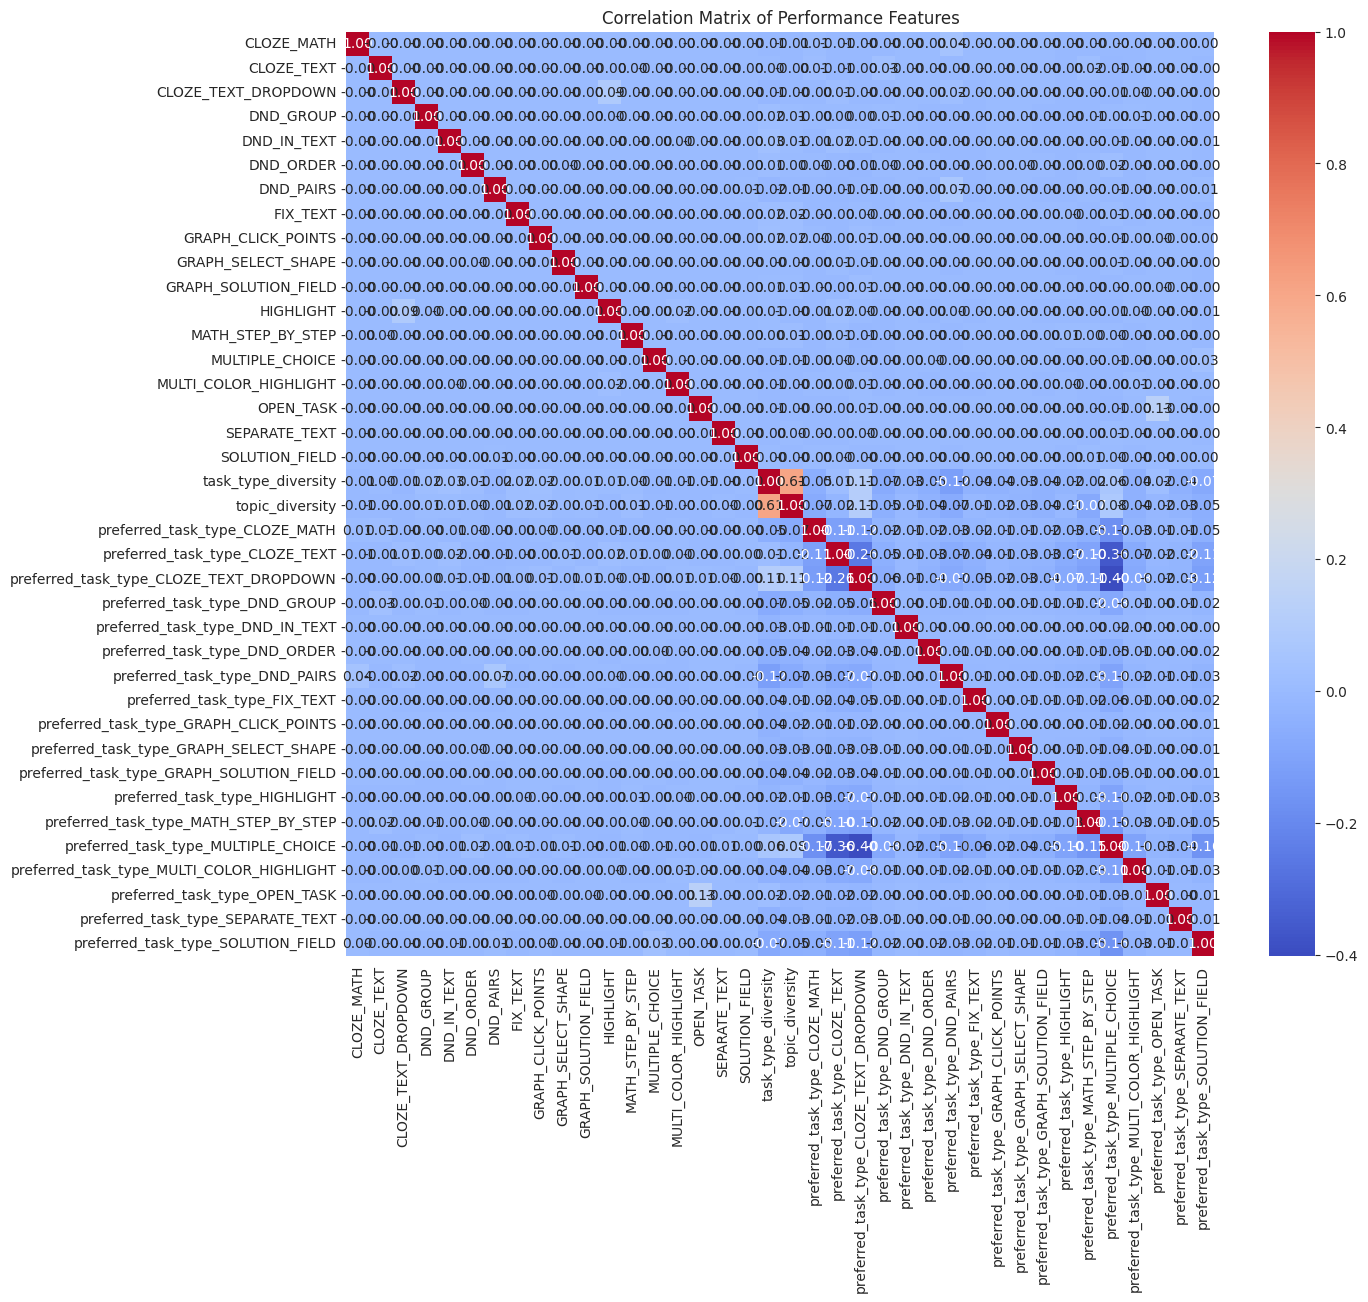

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot correlation matrix
plt.figure(figsize=(14, 12))
sns.heatmap(performance_features.drop('user_id', axis=1).corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix of Performance Features')
plt.show()


In [29]:
from sklearn.preprocessing import StandardScaler

# Remove user_id column before scaling
X = performance_features.drop(columns=['user_id'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Save scaled dataframe if you want
import pandas as pd
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled_df.head()


,CLOZE_MATH,CLOZE_TEXT,CLOZE_TEXT_DROPDOWN,DND_GROUP,DND_IN_TEXT,DND_ORDER,DND_PAIRS,FIX_TEXT,GRAPH_CLICK_POINTS,GRAPH_SELECT_SHAPE,...,preferred_task_type_GRAPH_CLICK_POINTS,preferred_task_type_GRAPH_SELECT_SHAPE,preferred_task_type_GRAPH_SOLUTION_FIELD,preferred_task_type_HIGHLIGHT,preferred_task_type_MATH_STEP_BY_STEP,preferred_task_type_MULTIPLE_CHOICE,preferred_task_type_MULTI_COLOR_HIGHLIGHT,preferred_task_type_OPEN_TASK,preferred_task_type_SEPARATE_TEXT,preferred_task_type_SOLUTION_FIELD
0,-0.015730,-0.020034,-0.020152,-0.024744,-0.023364,-0.021055,-0.023565,-0.014760,-0.009598,-0.010862,...,-0.028174,-0.058859,-0.067773,-0.136134,-0.206670,-0.747023,-0.140513,-0.036808,-0.051181,-0.219123
1,-0.015473,-0.020021,-0.020171,-0.024069,-0.023272,-0.021161,-0.023522,-0.014682,-0.007722,-0.010767,...,-0.028174,-0.058859,-0.067773,-0.136134,-0.206670,-0.747023,-0.140513,-0.036808,-0.051181,4.563648
2,-0.015517,-0.020083,-0.020180,-0.024102,-0.023562,-0.021021,-0.023530,-0.014863,-0.009387,-0.010745,...,-0.028174,-0.058859,-0.067773,-0.136134,-0.206670,1.338647,-0.140513,-0.036808,-0.051181,-0.219123
3,-0.015730,-0.020083,-0.020231,-0.024907,-0.023562,-0.021426,-0.023628,-0.014863,-0.009598,-0.010862,...,-0.028174,-0.058859,-0.067773,-0.136134,4.838626,-0.747023,-0.140513,-0.036808,-0.051181,-0.219123
4,-0.015730,-0.020083,-0.020035,-0.024907,-0.023562,-0.021426,-0.023628,-0.014863,-0.009598,-0.010862,...,-0.028174,-0.058859,-0.067773,-0.136134,-0.206670,1.338647,-0.140513,-0.036808,-0.051181,-0.219123


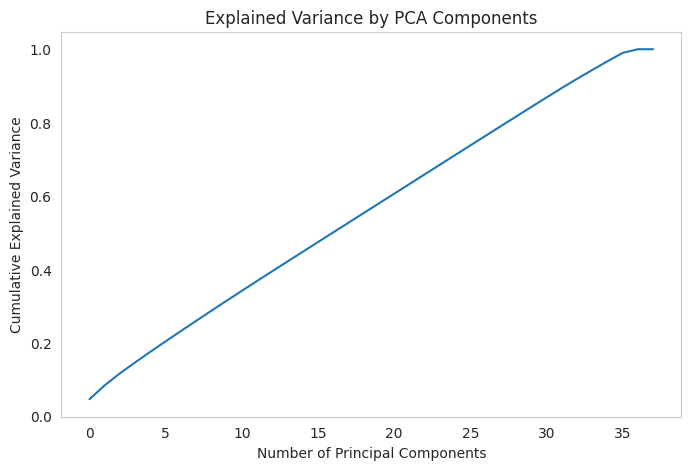

In [30]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Apply PCA keeping all components
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Plot explained variance
plt.figure(figsize=(8,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid()
plt.show()


## Correlation and Dimensionality Analysis of Performance Features

We first analyzed the correlation matrix of the performance-based features:

- No strong correlations were detected (all below 0.9).
- Each feature provides distinct behavioral information.
- Therefore, we decided to keep all performance features for the clustering step.

We then performed a PCA to explore the possibility of dimensionality reduction:

- The cumulative explained variance increased steadily without a clear "elbow".
- A large number of components would be needed to capture sufficient variance.
- As a result, we decided to cluster directly on the full set of scaled features without applying dimensionality reduction.

## 2.3 Temporal Behavior Features

### Step 1: Prepare daily activity 

In [31]:
from functools import reduce

events['event_date'] = pd.to_datetime(events['event_date'])
events = events.sort_values(by=['user_id', 'event_date'])

daily_activity = events.groupby(['user_id', pd.Grouper(key='event_date', freq='D')])['event_id'].count().unstack(fill_value=0)

# Calculate temporal features
temporal_features = daily_activity.apply(lambda x: {
    'active_days': (x > 0).sum(),
    'mean_events': x.mean(),
    'time_var': x.std(),
    'weekend_ratio': x[x.index.weekday >= 5].sum() / x.sum() if x.sum() > 0 else 0
}, axis=1)

# Convert Series of dicts to dataframe
temporal_df = pd.DataFrame(temporal_features.tolist(), index=temporal_features.index).reset_index()
temporal_df = temporal_df.rename(columns={'index': 'user_id'})


### Step 2: Time between events

In [32]:

events['time_diff'] = events.groupby('user_id')['event_date'].diff().dt.total_seconds()

event_time_stats = events.groupby('user_id')['time_diff'].agg(['mean', 'std']).reset_index()
event_time_stats.columns = ['user_id', 'avg_time_between_events', 'std_time_between_events']

### Step 3: Merge temporal features

In [33]:
temporal_final = temporal_df.merge(event_time_stats, on='user_id', how='left')

# Check
temporal_final.head()

,user_id,active_days,mean_events,time_var,weekend_ratio,avg_time_between_events,std_time_between_events
0,387604,100,8.113238,33.566561,0.045606,10424.632556,1.237126e+05
1,387605,54,5.748006,34.340947,0.185905,12543.136260,1.852490e+05
2,387608,87,3.762360,14.224332,0.130140,18650.922512,1.588434e+05
3,387613,5,0.339713,4.971908,0.089202,192817.528580,2.493983e+06
4,387615,12,0.853270,8.696562,0.145794,84626.140627,1.073315e+06


In [34]:
# Check missing values
temporal_final.isnull().sum()

user_id                    0
active_days                0
mean_events                0
time_var                   0
weekend_ratio              0
avg_time_between_events    2
std_time_between_events    2
dtype: int64

In [35]:
# Fill missing time differences with 0 (meaning: no info about time gaps)
temporal_final['avg_time_between_events'] = temporal_final['avg_time_between_events'].fillna(0)
temporal_final['std_time_between_events'] = temporal_final['std_time_between_events'].fillna(0)


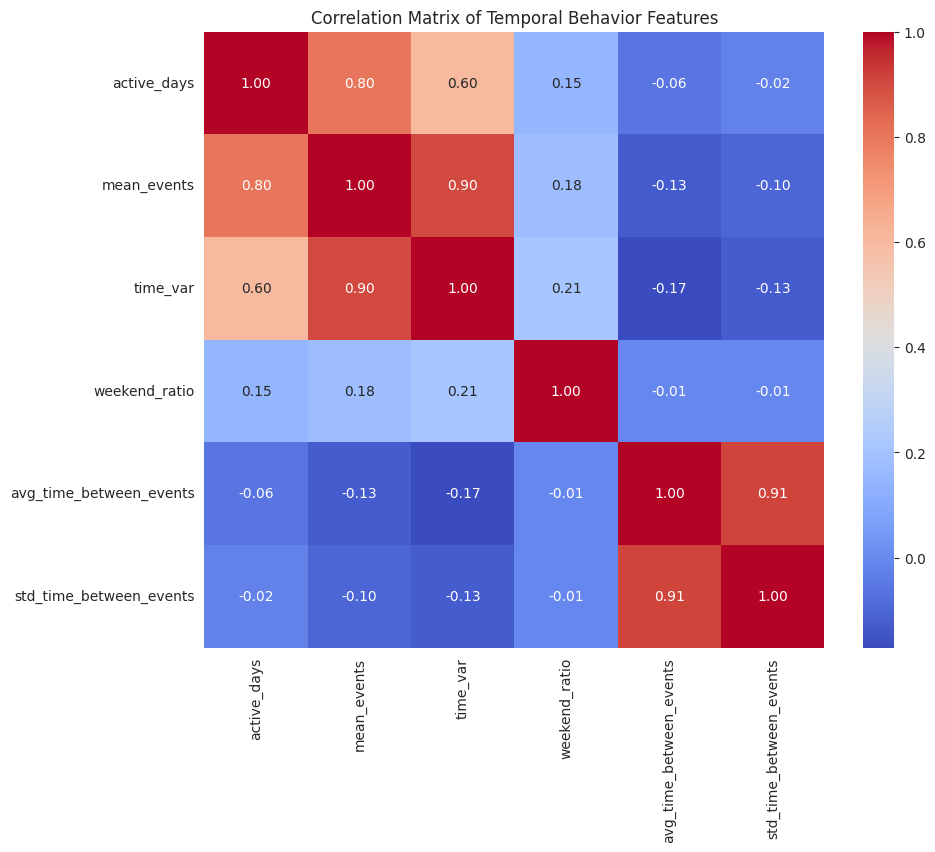

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot correlation heatmap for temporal features
plt.figure(figsize=(10,8))
sns.heatmap(temporal_final.drop(columns='user_id').corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix of Temporal Behavior Features')
plt.show()


In [37]:
# Keep only selected columns
temporal_final_clean = temporal_final[['user_id', 
                                       'active_days', 
                                       'mean_events', 
                                       'weekend_ratio', 
                                       'avg_time_between_events']]

# Check
temporal_final_clean.head()


,user_id,active_days,mean_events,weekend_ratio,avg_time_between_events
0,387604,100,8.113238,0.045606,10424.632556
1,387605,54,5.748006,0.185905,12543.136260
2,387608,87,3.762360,0.130140,18650.922512
3,387613,5,0.339713,0.089202,192817.528580
4,387615,12,0.853270,0.145794,84626.140627


## Cleaning and Feature Selection for Temporal Behavior

We analyzed the correlation matrix of temporal behavior features.

- `mean_events` and `time_var` were highly correlated (0.90).
- `avg_time_between_events` and `std_time_between_events` were also highly correlated (0.91).

To avoid redundancy, we kept:
- `active_days`
- `mean_events`
- `weekend_ratio`
- `avg_time_between_events`

This ensures a diverse set of temporal behavior indicators without multicollinearity.


## 2.3 Consistensy Features

### Step 1 - Number of weeks active


In [38]:
# Extract week number
events['week'] = events['event_date'].dt.isocalendar().week

# Number of unique weeks active
weeks_active = events.groupby('user_id')['week'].nunique().reset_index()
weeks_active.columns = ['user_id', 'weeks_active']
weeks_active.head()


,user_id,weeks_active
0,387604,38
1,387605,29
2,387608,41
3,387613,4
4,387615,8


### Step 2 - Number of "silent periods" (>7 days no activity)

In [39]:
# Time difference between consecutive events
events['event_gap_days'] = events.groupby('user_id')['event_date'].diff().dt.days

# Count how many times there is a gap >7 days
silent_periods = events.groupby('user_id')['event_gap_days'].apply(lambda x: (x > 7).sum()).reset_index()
silent_periods.columns = ['user_id', 'silent_periods']
silent_periods.head()


,user_id,silent_periods
0,387604,17
1,387605,22
2,387608,18
3,387613,3
4,387615,4


### Step 3 - Merge Consistency Features

In [40]:
# Merge weeks_active and silent_periods
consistency_features = weeks_active.merge(silent_periods, on='user_id', how='left')

# Check
consistency_features.head()


,user_id,weeks_active,silent_periods
0,387604,38,17
1,387605,29,22
2,387608,41,18
3,387613,4,3
4,387615,8,4


In [41]:
# Check missing values
consistency_features.isnull().sum()


user_id           0
weeks_active      0
silent_periods    0
dtype: int64

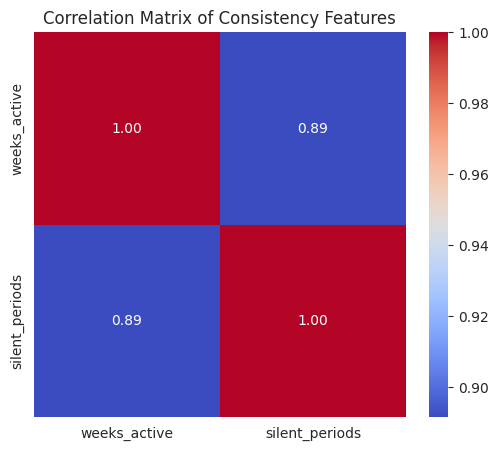

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot correlation matrix for consistency features
plt.figure(figsize=(6,5))
sns.heatmap(consistency_features.drop(columns='user_id').corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix of Consistency Features')
plt.show()


## Consistency Features Analysis

We created two consistency features:
- `weeks_active`: number of weeks the user was active
- `silent_periods`: number of inactivity gaps longer than 7 days

Their correlation was 0.89, indicating some relation but capturing complementary aspects of consistency.
Thus, both features were retained for clustering.


# 3. Merge and Correlation Analysis


In [43]:
from functools import reduce

# List of dataframes to merge
dfs_to_merge = [final_session_features, performance_features, temporal_final_clean, consistency_features]

# Merge all on user_id
features_final = reduce(lambda left, right: pd.merge(left, right, on='user_id', how='outer'), dfs_to_merge)

# Check
print(f"Shape of features_final: {features_final.shape}")
features_final.head()


Shape of features_final: (22470, 61)


,user_id,total_sessions,total_num_events,avg_session_duration_min,median_session_duration_min,std_session_duration_min,max_session_duration_min,min_session_duration_min,avg_num_events_per_session,avg_unique_topics_per_session,...,preferred_task_type_MULTI_COLOR_HIGHLIGHT,preferred_task_type_OPEN_TASK,preferred_task_type_SEPARATE_TEXT,preferred_task_type_SOLUTION_FIELD,active_days,mean_events,weekend_ratio,avg_time_between_events,weeks_active,silent_periods
0,387604,61.0,1105.0,12963.096278,1.331083,64843.133625,492921.146800,0.000000,18.114754,0.918033,...,False,False,False,False,100,8.113238,0.045606,10424.632556,38,17
1,387605,67.0,742.0,29595.661530,3.315933,98793.615011,531286.253133,0.000000,11.074627,0.955224,...,False,False,False,True,54,5.748006,0.185905,12543.136260,29,22
2,387608,31.0,469.0,11904.947317,3.627667,40661.940478,217246.262683,0.000000,15.129032,0.548387,...,False,False,False,False,87,3.762360,0.130140,18650.922512,41,18
3,387613,4.0,31.0,1.019733,0.923208,0.581060,1.766600,0.465917,7.750000,1.000000,...,False,False,False,False,5,0.339713,0.089202,192817.528580,4,3
4,387615,2.0,48.0,9.675450,9.675450,0.642996,10.130117,9.220783,24.000000,1.000000,...,False,False,False,False,12,0.853270,0.145794,84626.140627,8,4


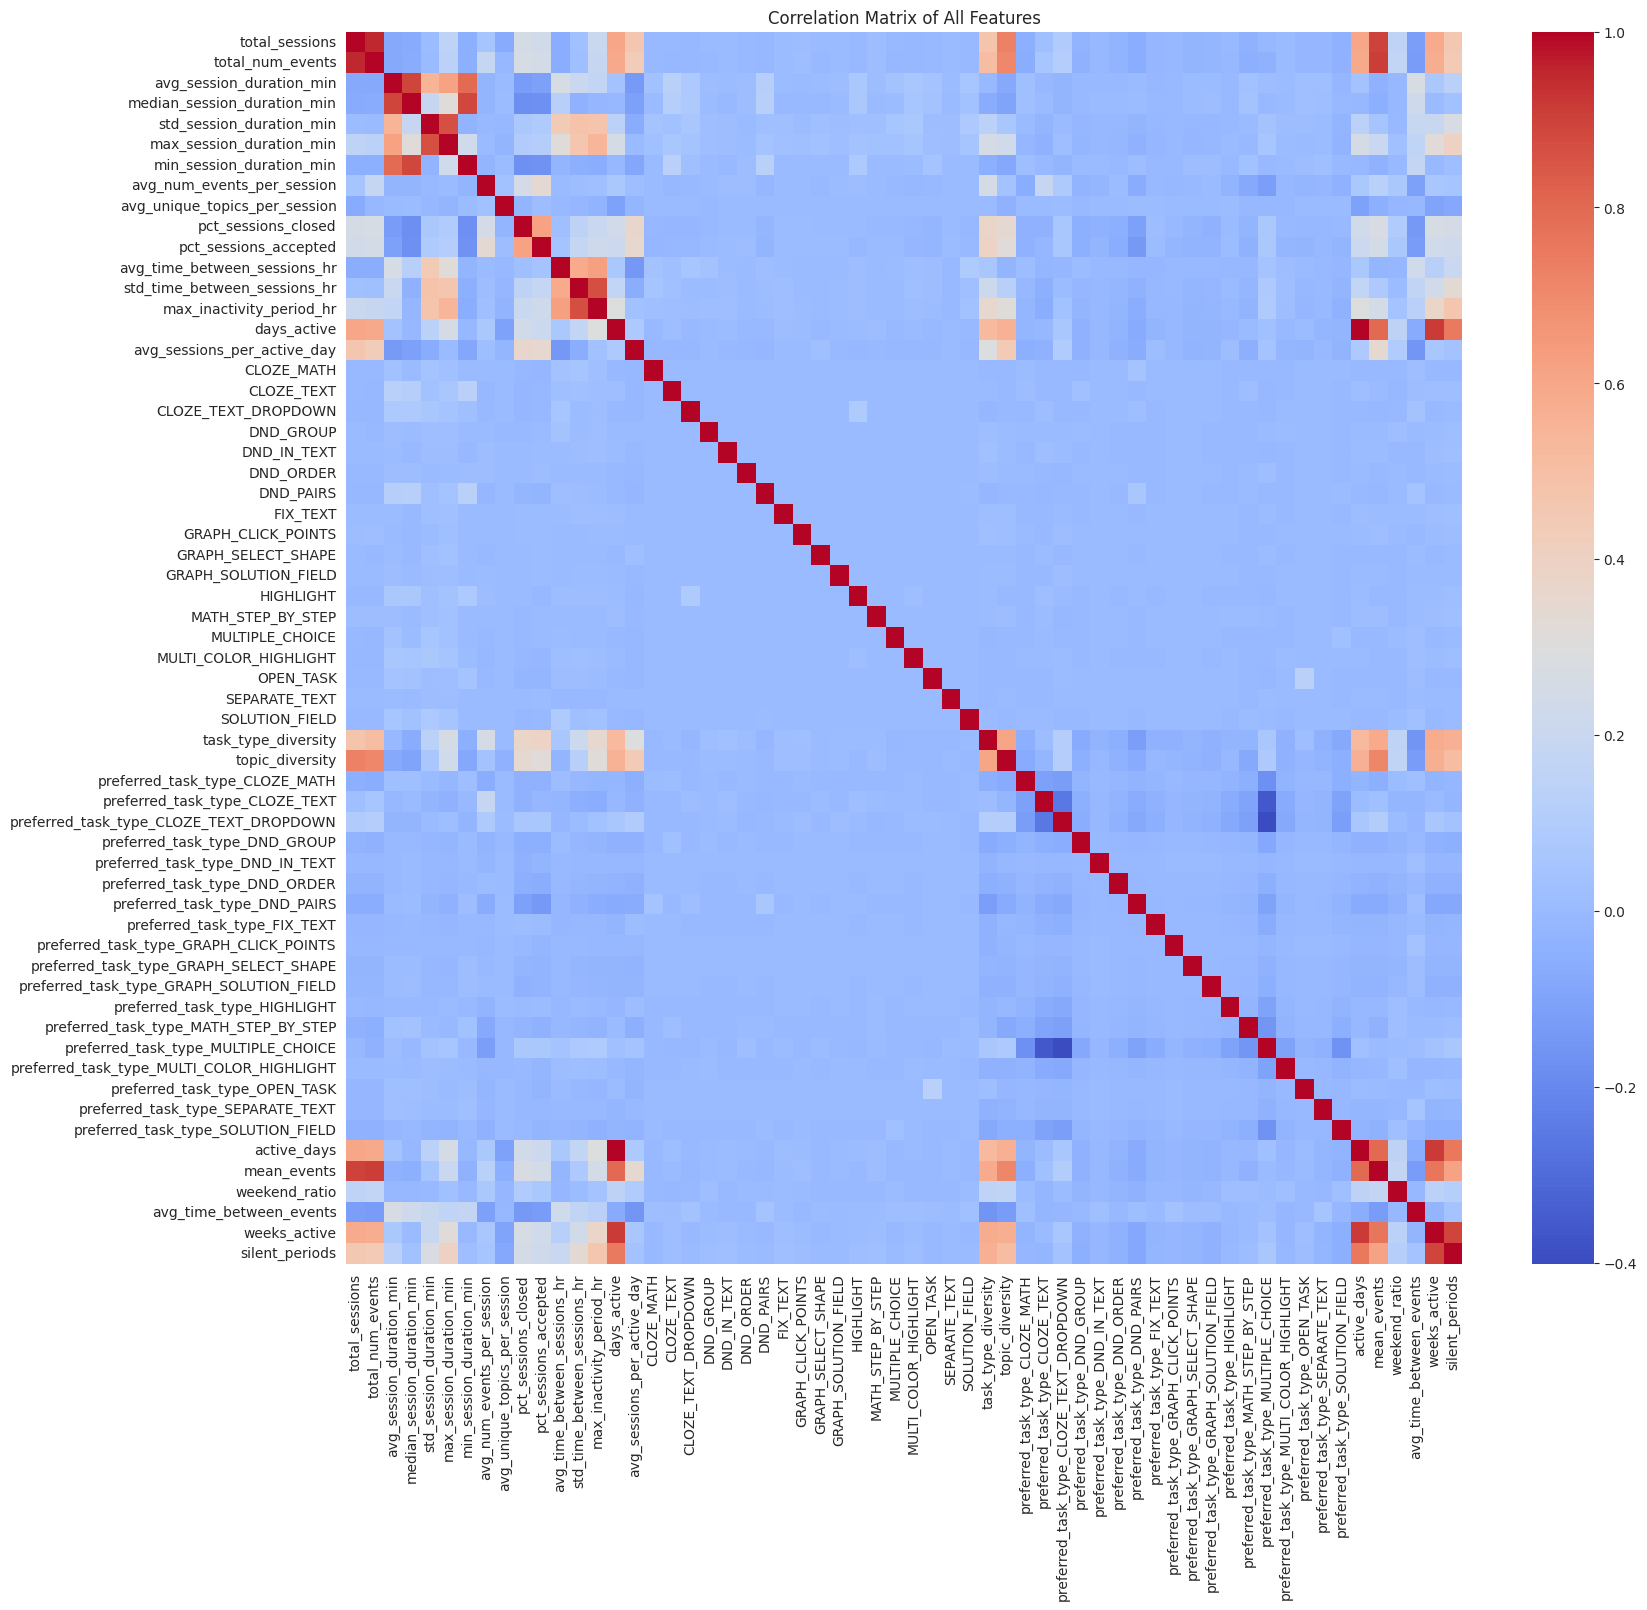

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

# Drop user_id for correlation
plt.figure(figsize=(18, 16))
sns.heatmap(features_final.drop(columns='user_id').corr(), annot=False, cmap='coolwarm')
plt.title('Correlation Matrix of All Features')
plt.show()


# 3. Correlation Analysis and Feature Selection

We analyzed the full correlation matrix across session, performance, temporal, and consistency features.

- Within session-based features, high correlations were observed between `total_sessions` and `total_num_events`, as well as among session duration statistics.
- To avoid redundancy, we dropped `total_num_events` and `min_session_duration_min`.

Performance, temporal, and consistency features showed acceptable levels of correlation, and all were retained.

This feature selection ensures a diverse and independent set of behavioral indicators for clustering.


In [45]:
# --- 1. Drop redundant features from features_final ---

# Columns to drop based on correlation analysis
columns_to_drop = [
    'total_num_events',          # Highly correlated with total_sessions
    'min_session_duration_min',  # Low info + correlated with other durations
    'median_session_duration_min'  # Optional: you can comment this line if you want to keep it
]

# Drop them
features_final_clean = features_final.drop(columns=columns_to_drop)

# Check the new shape
print(f"Shape after dropping redundant features: {features_final_clean.shape}")
features_final_clean.head()


Shape after dropping redundant features: (22470, 58)


,user_id,total_sessions,avg_session_duration_min,std_session_duration_min,max_session_duration_min,avg_num_events_per_session,avg_unique_topics_per_session,pct_sessions_closed,pct_sessions_accepted,avg_time_between_sessions_hr,...,preferred_task_type_MULTI_COLOR_HIGHLIGHT,preferred_task_type_OPEN_TASK,preferred_task_type_SEPARATE_TEXT,preferred_task_type_SOLUTION_FIELD,active_days,mean_events,weekend_ratio,avg_time_between_events,weeks_active,silent_periods
0,387604,61.0,12963.096278,64843.133625,492921.146800,18.114754,0.918033,0.982143,0.826087,229.595889,...,False,False,False,False,100,8.113238,0.045606,10424.632556,38,17
1,387605,67.0,29595.661530,98793.615011,531286.253133,11.074627,0.955224,0.984375,1.000000,187.273808,...,False,False,False,True,54,5.748006,0.185905,12543.136260,29,22
2,387608,31.0,11904.947317,40661.940478,217246.262683,15.129032,0.548387,1.000000,1.000000,407.203174,...,False,False,False,False,87,3.762360,0.130140,18650.922512,41,18
3,387613,4.0,1.019733,0.581060,1.766600,7.750000,1.000000,0.750000,1.000000,439.497068,...,False,False,False,False,5,0.339713,0.089202,192817.528580,4,3
4,387615,2.0,9.675450,0.642996,10.130117,24.000000,1.000000,1.000000,1.000000,0.172846,...,False,False,False,False,12,0.853270,0.145794,84626.140627,8,4


In [46]:
from sklearn.feature_selection import VarianceThreshold

# Remove very low-variance features (threshold = 0.01 is common)
selector = VarianceThreshold(threshold=0.01)
features_selected = selector.fit_transform(features_final_clean.drop(columns='user_id'))

print(f"Original shape: {features_final_clean.drop(columns='user_id').shape}")
print(f"After Variance Threshold: {features_selected.shape}")


# Recover the column names that were kept
selected_columns = features_final_clean.drop(columns=['user_id']).columns[selector.get_support()]

# Check
print(f"Selected {len(selected_columns)} features:")
print(selected_columns.tolist())


Original shape: (22470, 57)
After Variance Threshold: (22470, 48)
Selected 48 features:
['total_sessions', 'avg_session_duration_min', 'std_session_duration_min', 'max_session_duration_min', 'avg_num_events_per_session', 'pct_sessions_closed', 'pct_sessions_accepted', 'avg_time_between_sessions_hr', 'std_time_between_sessions_hr', 'max_inactivity_period_hr', 'days_active', 'avg_sessions_per_active_day', 'CLOZE_MATH', 'CLOZE_TEXT', 'CLOZE_TEXT_DROPDOWN', 'DND_GROUP', 'DND_IN_TEXT', 'DND_ORDER', 'DND_PAIRS', 'FIX_TEXT', 'GRAPH_CLICK_POINTS', 'GRAPH_SELECT_SHAPE', 'GRAPH_SOLUTION_FIELD', 'HIGHLIGHT', 'MATH_STEP_BY_STEP', 'MULTIPLE_CHOICE', 'MULTI_COLOR_HIGHLIGHT', 'OPEN_TASK', 'SEPARATE_TEXT', 'SOLUTION_FIELD', 'task_type_diversity', 'topic_diversity', 'preferred_task_type_CLOZE_MATH', 'preferred_task_type_CLOZE_TEXT', 'preferred_task_type_CLOZE_TEXT_DROPDOWN', 'preferred_task_type_DND_GROUP', 'preferred_task_type_DND_PAIRS', 'preferred_task_type_HIGHLIGHT', 'preferred_task_type_MATH_STEP

# 4. Prepare Final Feature Table
After merging and cleaning all feature families, we applied a Variance Threshold analysis with a threshold of 0.01.

- 57 features were initially available.
- 48 features were retained after removing near-constant features.

This step ensures that only informative and varying features are used for clustering.


In [47]:
import pandas as pd

# Rebuild clean dataframe
X_selected_df = pd.DataFrame(features_selected, columns=selected_columns)

# Add user_id back if you want
X_selected_df['user_id'] = features_final_clean['user_id'].values

# Check
X_selected_df.head()


,total_sessions,avg_session_duration_min,std_session_duration_min,max_session_duration_min,avg_num_events_per_session,pct_sessions_closed,pct_sessions_accepted,avg_time_between_sessions_hr,std_time_between_sessions_hr,max_inactivity_period_hr,...,preferred_task_type_MULTIPLE_CHOICE,preferred_task_type_MULTI_COLOR_HIGHLIGHT,preferred_task_type_SOLUTION_FIELD,active_days,mean_events,weekend_ratio,avg_time_between_events,weeks_active,silent_periods,user_id
0,61.0,12963.096278,64843.133625,492921.1468,18.114754,0.982143,0.826087,229.595889,425.555724,1676.341603,...,False,False,False,100,8.113238,0.045606,10424.632556,38,17,387604
1,67.0,29595.66153,98793.615011,531286.253133,11.074627,0.984375,1.0,187.273808,464.944778,3120.276084,...,False,False,True,54,5.748006,0.185905,12543.13626,29,22,387605
2,31.0,11904.947317,40661.940478,217246.262683,15.129032,1.0,1.0,407.203174,787.446374,3049.412006,...,True,False,False,87,3.76236,0.13014,18650.922512,41,18,387608
3,4.0,1.019733,0.58106,1.7666,7.75,0.75,1.0,439.497068,548.218223,1053.816563,...,False,False,False,5,0.339713,0.089202,192817.52858,4,3,387613
4,2.0,9.67545,0.642996,10.130117,24.0,1.0,1.0,0.172846,0.0,0.172846,...,True,False,False,12,0.85327,0.145794,84626.140627,8,4,387615


In [48]:
from sklearn.preprocessing import StandardScaler

# Separate user_id and features
X_features_final = X_selected_df.drop(columns=['user_id'])
user_ids_final = X_selected_df['user_id']

# Apply scaling
scaler = StandardScaler()
X_scaled_final_clustering = scaler.fit_transform(X_features_final)
X_scaled_final_clustering = pd.DataFrame(X_scaled_final_clustering, columns=X_features_final.columns)

# Optionally wrap back into a DataFrame for easier analysis
import pandas as pd
X_scaled_final_df = X_scaled_final_clustering.copy()
X_scaled_final_df['user_id'] = user_ids_final.values

# Check
X_scaled_final_df.head()


,total_sessions,avg_session_duration_min,std_session_duration_min,max_session_duration_min,avg_num_events_per_session,pct_sessions_closed,pct_sessions_accepted,avg_time_between_sessions_hr,std_time_between_sessions_hr,max_inactivity_period_hr,...,preferred_task_type_MULTIPLE_CHOICE,preferred_task_type_MULTI_COLOR_HIGHLIGHT,preferred_task_type_SOLUTION_FIELD,active_days,mean_events,weekend_ratio,avg_time_between_events,weeks_active,silent_periods,user_id
0,2.178260,0.040976,1.091944,3.761500,0.114304,0.591600,0.156031,-0.027532,0.017587,0.189341,...,-0.747023,-0.140513,-0.219123,11.997447,5.806972,-0.183118,-0.325153,8.649997,6.477566,387604
1,2.445658,0.468185,1.881149,4.092042,-0.519263,0.598772,0.574557,-0.088120,0.066162,0.865307,...,-0.747023,-0.140513,4.563648,6.115191,3.930310,0.603994,-0.304138,6.354716,8.630960,387605
2,0.841269,0.013797,0.529834,1.386367,-0.154392,0.648977,0.574557,0.226730,0.463874,0.832133,...,1.338647,-0.140513,-0.219123,10.335071,2.354826,0.291138,-0.243549,9.415091,6.908245,387608
3,-0.362023,-0.291957,-0.415370,-0.485347,-0.818458,-0.154303,0.574557,0.272961,0.168855,-0.102089,...,-0.747023,-0.140513,-0.219123,-0.150690,-0.360828,0.061465,1.484182,-0.021065,0.448063,387613
4,-0.451156,-0.291734,-0.415368,-0.485275,0.643939,0.648977,0.574557,-0.355972,-0.507214,-0.595344,...,1.338647,-0.140513,-0.219123,0.744436,0.046646,0.378964,0.410925,0.999060,0.878742,387615


In [49]:
# Quick statistical summary
X_scaled_final_df.describe()


,total_sessions,avg_session_duration_min,std_session_duration_min,max_session_duration_min,avg_num_events_per_session,pct_sessions_closed,pct_sessions_accepted,avg_time_between_sessions_hr,std_time_between_sessions_hr,max_inactivity_period_hr,...,preferred_task_type_MULTIPLE_CHOICE,preferred_task_type_MULTI_COLOR_HIGHLIGHT,preferred_task_type_SOLUTION_FIELD,active_days,mean_events,weekend_ratio,avg_time_between_events,weeks_active,silent_periods,user_id
count,1.963000e+04,1.963000e+04,1.963000e+04,19630.000000,1.963000e+04,1.963000e+04,1.963000e+04,19630.000000,1.963000e+04,1.963000e+04,...,2.143400e+04,2.143400e+04,2.143400e+04,2.247000e+04,2.247000e+04,2.247000e+04,22470.000000,2.247000e+04,22470.000000,22470.000000
mean,2.316594e-17,1.158297e-17,-2.316594e-17,0.000000,1.151058e-16,-4.633187e-17,8.108078e-17,0.000000,-1.158297e-17,-4.633187e-17,...,-6.364850e-17,-2.652021e-17,-3.845431e-17,-2.023798e-17,-2.023798e-17,1.011899e-17,0.000000,6.071393e-17,0.000000,407695.489542
std,1.000025e+00,1.000025e+00,1.000025e+00,1.000025,1.000025e+00,1.000025e+00,1.000025e+00,1.000025,1.000025e+00,1.000025e+00,...,1.000023e+00,1.000023e+00,1.000023e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022,1.000022e+00,1.000022,11800.847723
min,-4.957220e-01,-2.919828e-01,-4.153834e-01,-0.485362,-1.425915e+00,-2.564143e+00,-1.831966e+00,-0.356219,-5.072139e-01,-5.954253e-01,...,-7.470229e-01,-1.405135e-01,-2.191229e-01,-6.621906e-01,-6.291035e-01,-4.389829e-01,-0.428566,-7.861591e-01,-0.843973,387604.000000
25%,-4.511556e-01,-2.918388e-01,-4.153320e-01,-0.485270,-5.409774e-01,-1.543032e-01,1.233336e-01,-0.356127,-5.072139e-01,-5.953802e-01,...,-7.470229e-01,-1.405135e-01,-2.191229e-01,-5.343154e-01,-4.937004e-01,-4.389829e-01,-0.406918,-5.311278e-01,-0.843973,398001.250000
50%,-3.174565e-01,-2.850633e-01,-4.086639e-01,-0.470655,-1.283093e-01,4.883207e-01,5.745565e-01,-0.316087,-4.527768e-01,-5.167953e-01,...,-7.470229e-01,-1.405135e-01,-2.191229e-01,-2.785652e-01,-3.152721e-01,-4.389829e-01,-0.276284,-2.760966e-01,-0.413294,406203.500000
75%,3.907447e-02,-1.253779e-01,-7.101247e-02,-0.013252,3.019629e-01,6.489766e-01,5.745565e-01,-0.037022,9.610756e-02,1.856635e-01,...,1.338647e+00,-1.405135e-01,-2.191229e-01,1.050602e-01,6.815906e-02,-1.792739e-01,-0.003940,2.339659e-01,0.448063,415909.750000
max,2.789306e+01,1.893648e+01,1.386980e+01,7.002381,1.432297e+01,6.489766e-01,5.745565e-01,20.379959,1.056108e+01,6.185469e+00,...,1.338647e+00,7.116754e+00,4.563648e+00,3.041147e+01,1.968769e+01,5.171297e+00,28.156110,1.196540e+01,8.630960,432020.000000


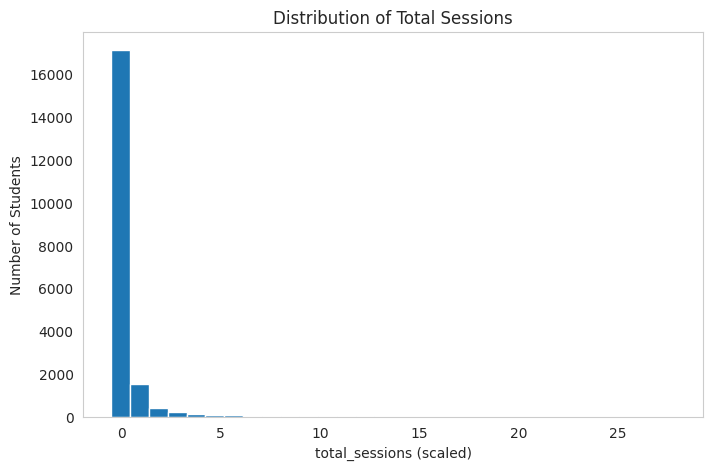

In [50]:
import matplotlib.pyplot as plt

# Example: distribution of total_sessions
plt.figure(figsize=(8,5))
plt.hist(X_scaled_final_df['total_sessions'], bins=30)
plt.title('Distribution of Total Sessions')
plt.xlabel('total_sessions (scaled)')
plt.ylabel('Number of Students')
plt.grid()
plt.show()


# 5. Save for Clustering


In [51]:
import pickle

# 1. Save scaled features + user id
X_scaled_final_df.to_csv('final_scaled_features_with_userid.csv', index=False)

# 2. Save clean feature matrix for clustering
X_scaled_final_clustering.to_csv('final_features_for_clustering.csv', index=False)
#np.save('final_features_for_clustering.npy', X_scaled_final)

# 3. Save scaler (optional but good)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("✅ Saved all files for clustering.")


✅ Saved all files for clustering.


*Your discussion about your processing decisions goes here*

## Task 2: Model Building

Train a model for your research question.

### Prepare datasets for clustering
We will use different DataFrames in order to have a better overview on the clustering. Now that we have the features, we need to prepare them to be exactly on the correct format.§

In [52]:
from utils.memory_usage import see_memory_usage
see_memory_usage(globals().items())

,Variable,Type,Size
0,df_events,DataFrame,20.06 GB
1,events,DataFrame,19.84 GB
2,transactions,DataFrame,5.12 GB
3,df_transactions,DataFrame,4.65 GB
4,daily_activity,DataFrame,215.32 MB
5,X_selected_df,DataFrame,68.32 MB
6,X_features_final,DataFrame,67.98 MB
7,features_final,DataFrame,42.37 MB
8,features_final_clean,DataFrame,41.34 MB
9,session_features,DataFrame,25.42 MB


In [53]:
# Free some memory by deleting the biggest DataFrames
del transactions, events, users, X_selected_df, features_final, df_events, df_transactions, daily_activity
import gc
gc.collect()

306

In [54]:
# For the final Dataset

# Since the least number of NaNs in a row is 12, those rows are not very important for our clustering of the entire dataset:
nan_df = X_scaled_final_clustering.isnull().sum(axis=1)
print(f'Number of row with at least one NaN: {len(nan_df)}')
print(f'Min number of NaNs in a single row: {nan_df[nan_df > 0].sort_values().iloc[0]}')
del nan_df

# Then, we drop the NaNs (the clustering algorithms does not do well on NaN values)
X_scaled_final_clustering.dropna(how='any', inplace=True)

Number of row with at least one NaN: 22470
Min number of NaNs in a single row: 12


# For entire dataset

### Hyperparameter tuning
In order to get good results, hyperparameter finetuning is mandatory. To do this, let's do a simple grid search: run our HDBSCAN clustering on many hyperparameters and keep the bests. The most important hyperparameters for DBSCAN are 'min_cluster_size', which decides from which number of points a cluster can be considered, and 'cluster_selection_epsilon' which decides at which point to similar clusters must be considered as one.

In [114]:
# Initialize the parameters to be tuned
min_cluster_size_list = [10, 30, 50, 70]
cluster_selection_epsilon_list = [0.0, 2.0, 4.0, 6.0, 8.0, 10.0]

# Perform hyperparameters tuning for the entire dataset
score_list, nb_clusters_list, nb_outliers_list = run_hdbscan_grid_search(X_scaled_final_clustering, min_cluster_size_list, cluster_selection_epsilon_list)

For min_cluster_size=10 and cluster_selection_epsilon=0.0:
	Nb clusters: 36
	Nb outliers: 10158
	Silhouette score: -0.10735474498846909
For min_cluster_size=10 and cluster_selection_epsilon=2.0:
	Nb clusters: 14
	Nb outliers: 2977
	Silhouette score: 0.07694640703699414
For min_cluster_size=10 and cluster_selection_epsilon=4.0:
	Nb clusters: 9
	Nb outliers: 571
	Silhouette score: 0.21980159076443567
For min_cluster_size=10 and cluster_selection_epsilon=6.0:
	Nb clusters: 6
	Nb outliers: 234
	Silhouette score: 0.3210849930976603
For min_cluster_size=10 and cluster_selection_epsilon=8.0:
	Nb clusters: 3
	Nb outliers: 152
	Silhouette score: 0.40242050068616786
For min_cluster_size=10 and cluster_selection_epsilon=10.0:
	Nb clusters: 3
	Nb outliers: 152
	Silhouette score: 0.40242050068616786
-----------------------------------
For min_cluster_size=30 and cluster_selection_epsilon=0.0:
	Nb clusters: 16
	Nb outliers: 7094
	Silhouette score: 0.029350287593603946
For min_cluster_size=30 and clu

### Plot the heatmap
We now have to analyze the hyperparameters in order to keep the best ones.

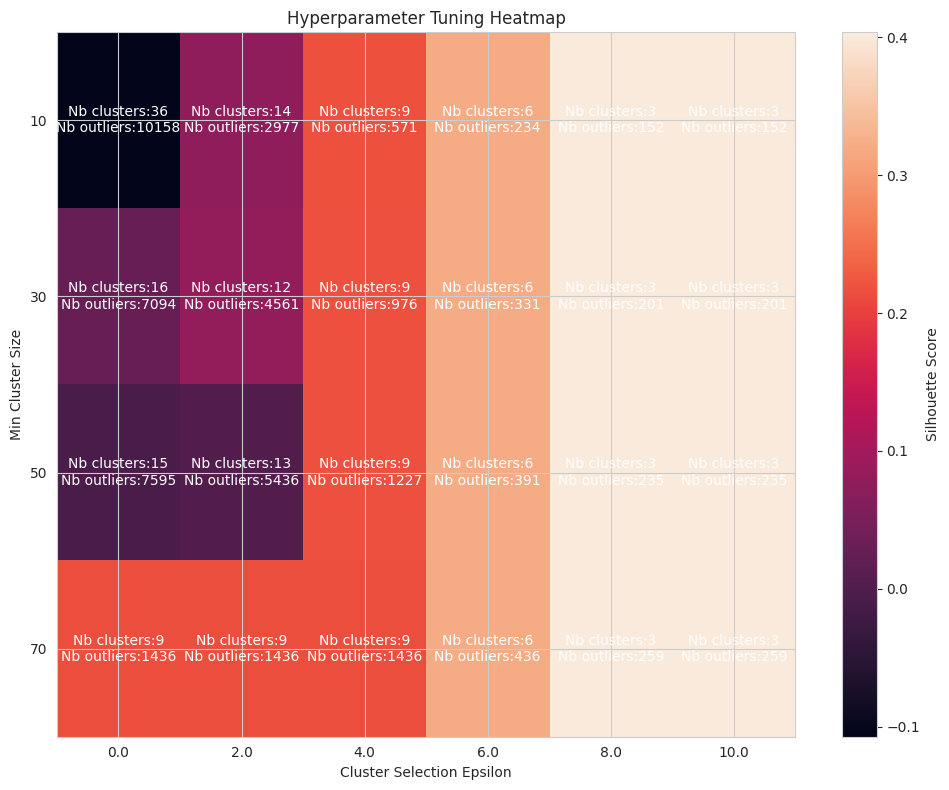

In [115]:
# Let's plot the heatmap
plot_hyperparameter_tuning_heatmap(score_list, min_cluster_size_list, cluster_selection_epsilon_list, nb_clusters_list, nb_outliers_list)

### Analysing the gridsearch
The insights given by the gridsearch analysis shows us that the min cluster size does not really influence the results for good ones. Moreover, the cluster selection epsilon permits to drastically decrease the number of clusters and increase the silhouette score. It is up to us to decide which number of clusters best represent what we want to show:
- Nb clusters 6 (with outliers): This is the most number of clusters we can have with a 'correct' silhouette score (0.32). Since this is an acceptable score, the clusters are however not really well separated.
- Nb clusters 3 (with outliers): With a silhouette score of 0.40, this is the best we could have. We have now to decide if three clusters suffices to extract interesting behaviors.

### Fit and analyse the clusters
Now that we found some good hyperparameters, let's watch the clusters and analyse those.

In [116]:
entire_dataset_6clusters, entire_dataset_6clusters_centroids = init_fit_hdbscan_clustering(X_scaled_final_clustering, min_cluster_size=30, cluster_selection_epsilon=6.0)

Model fitted. Num of clusters found: 5
Labels and probabilities added


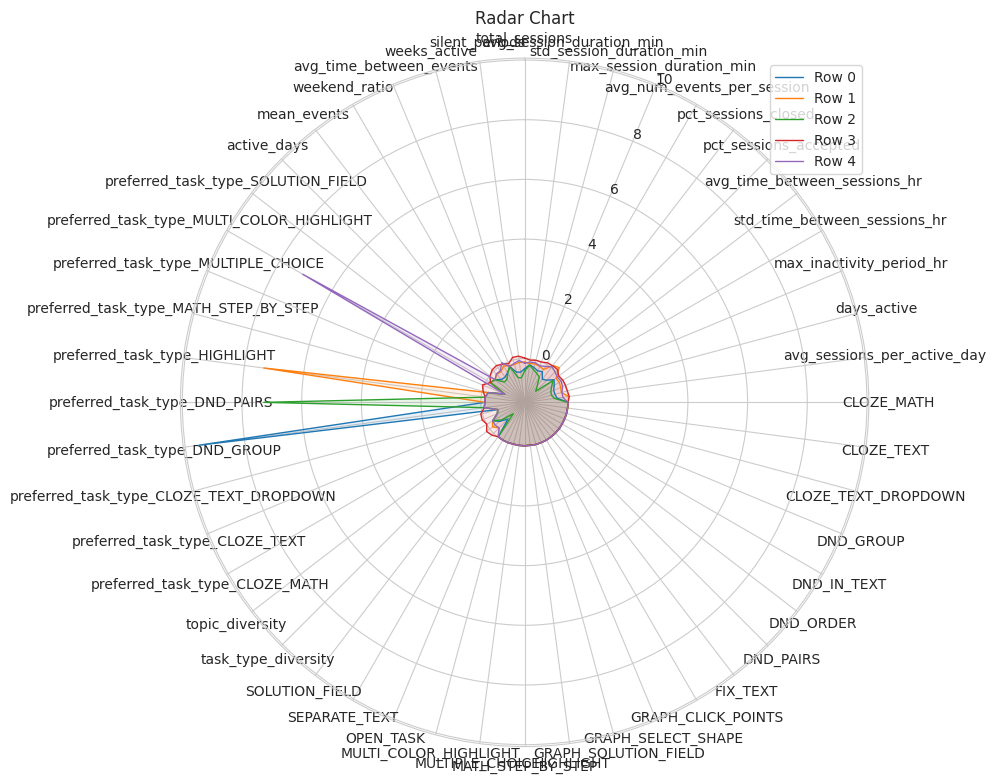

In [117]:
# Create radar chart
create_radar_chart(entire_dataset_6clusters_centroids)

In [118]:
entire_dataset_6clusters['labels'].value_counts()

labels
 3    17431
 1      350
 2      338
-1      331
 4      315
 0      180
Name: count, dtype: int64

Model fitted. Num of clusters found: 2
Labels and probabilities added


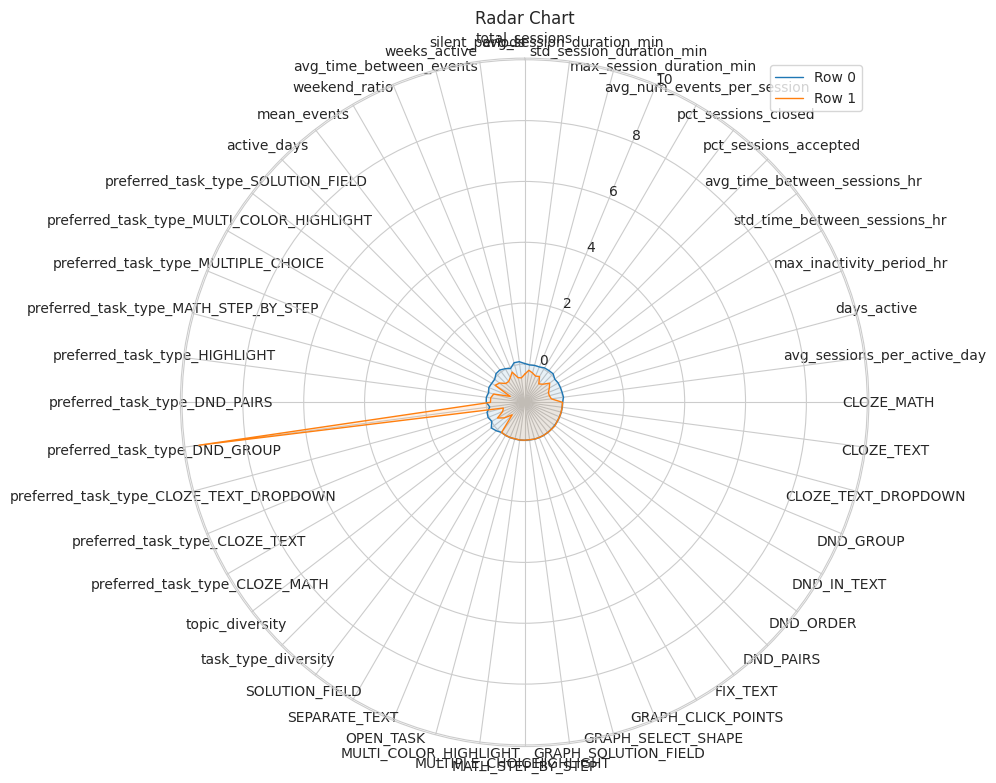

In [119]:
entire_dataset_3clusters, entire_dataset_3clusters_centroids = init_fit_hdbscan_clustering(X_scaled_final_clustering, min_cluster_size=30, cluster_selection_epsilon=8.0)
create_radar_chart(entire_dataset_3clusters_centroids)

In [120]:
entire_dataset_3clusters['labels'].value_counts()

labels
 0    18564
-1      201
 1      180
Name: count, dtype: int64

#### Analysis
We directly see that the

# For dataset without preferred columns
We saw that the columns 'preferred_*' are mainly determining the clusters. This make sense since those are binary features and then, entries having the same value would be considered very similar since they have exactly the same values. To counter this, we could just remove these columns.

In [121]:
X_without_preferred = X_scaled_final_clustering.drop(['preferred_task_type_MULTI_COLOR_HIGHLIGHT', 'preferred_task_type_CLOZE_MATH', 'preferred_task_type_CLOZE_TEXT', 'preferred_task_type_CLOZE_TEXT_DROPDOWN', 'preferred_task_type_DND_GROUP', 'preferred_task_type_DND_PAIRS', 'preferred_task_type_HIGHLIGHT', 'preferred_task_type_MATH_STEP_BY_STEP', 'preferred_task_type_MULTIPLE_CHOICE', 'preferred_task_type_SOLUTION_FIELD'], axis=1)

In [122]:
X_without_preferred.head()

,total_sessions,avg_session_duration_min,std_session_duration_min,max_session_duration_min,avg_num_events_per_session,pct_sessions_closed,pct_sessions_accepted,avg_time_between_sessions_hr,std_time_between_sessions_hr,max_inactivity_period_hr,...,SEPARATE_TEXT,SOLUTION_FIELD,task_type_diversity,topic_diversity,active_days,mean_events,weekend_ratio,avg_time_between_events,weeks_active,silent_periods
0,2.178260,0.040976,1.091944,3.761500,0.114304,0.591600,0.156031,-0.027532,0.017587,0.189341,...,-0.009419,-0.016840,1.623130,2.142383,11.997447,5.806972,-0.183118,-0.325153,8.649997,6.477566
1,2.445658,0.468185,1.881149,4.092042,-0.519263,0.598772,0.574557,-0.088120,0.066162,0.865307,...,-0.009490,-0.016743,3.379855,4.961933,6.115191,3.930310,0.603994,-0.304138,6.354716,8.630960
2,0.841269,0.013797,0.529834,1.386367,-0.154392,0.648977,0.574557,0.226730,0.463874,0.832133,...,-0.009574,-0.016784,1.037556,1.708606,10.335071,2.354826,0.291138,-0.243549,9.415091,6.908245
3,-0.362023,-0.291957,-0.415370,-0.485347,-0.818458,-0.154303,0.574557,0.272961,0.168855,-0.102089,...,-0.009574,-0.016778,-1.304744,-0.026501,-0.150690,-0.360828,0.061465,1.484182,-0.021065,0.448063
4,-0.451156,-0.291734,-0.415368,-0.485275,0.643939,0.648977,0.574557,-0.355972,-0.507214,-0.595344,...,-0.009425,-0.016840,-1.011957,-0.677167,0.744436,0.046646,0.378964,0.410925,0.999060,0.878742


In [123]:
# Initialize the parameters to be tuned
min_cluster_size_list = [2, 4, 6, 8, 10, 12]
cluster_selection_epsilon_list = [2.5, 3.0, 3.5, 4.0, 4.5, 5.0]

# Perform hyperparameters tuning for the entire dataset
score_list, nb_clusters_list, nb_outliers_list = run_hdbscan_grid_search(X_without_preferred, min_cluster_size_list, cluster_selection_epsilon_list)

For min_cluster_size=2 and cluster_selection_epsilon=2.5:
	Nb clusters: 123
	Nb outliers: 429
	Silhouette score: -0.01622892744555284
For min_cluster_size=2 and cluster_selection_epsilon=3.0:
	Nb clusters: 78
	Nb outliers: 233
	Silhouette score: 0.026304102635506303
For min_cluster_size=2 and cluster_selection_epsilon=3.5:
	Nb clusters: 52
	Nb outliers: 159
	Silhouette score: 0.17900055004517706
For min_cluster_size=2 and cluster_selection_epsilon=4.0:
	Nb clusters: 44
	Nb outliers: 106
	Silhouette score: 0.33111542873257427
For min_cluster_size=2 and cluster_selection_epsilon=4.5:
	Nb clusters: 42
	Nb outliers: 82
	Silhouette score: 0.3421060751576384
For min_cluster_size=2 and cluster_selection_epsilon=5.0:
	Nb clusters: 38
	Nb outliers: 67
	Silhouette score: 0.4060670034513299
-----------------------------------
For min_cluster_size=4 and cluster_selection_epsilon=2.5:
	Nb clusters: 17
	Nb outliers: 816
	Silhouette score: 0.15107852224023194
For min_cluster_size=4 and cluster_select

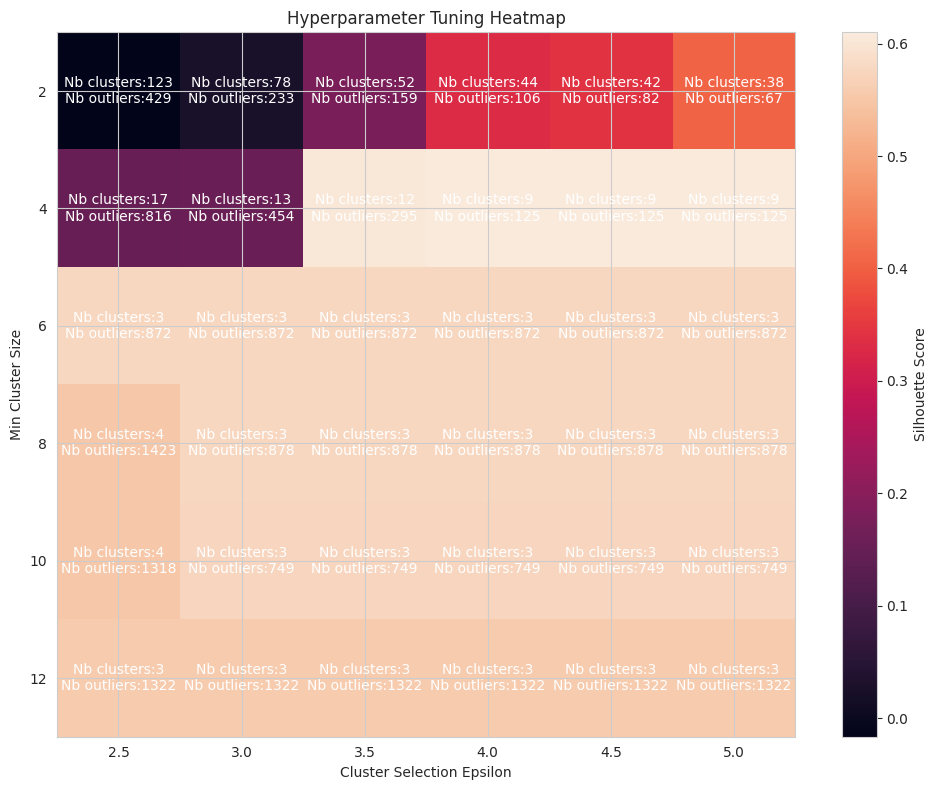

In [124]:
plot_hyperparameter_tuning_heatmap(score_list, min_cluster_size_list, cluster_selection_epsilon_list, nb_clusters_list, nb_outliers_list)

Model fitted. Num of clusters found: 8
Labels and probabilities added


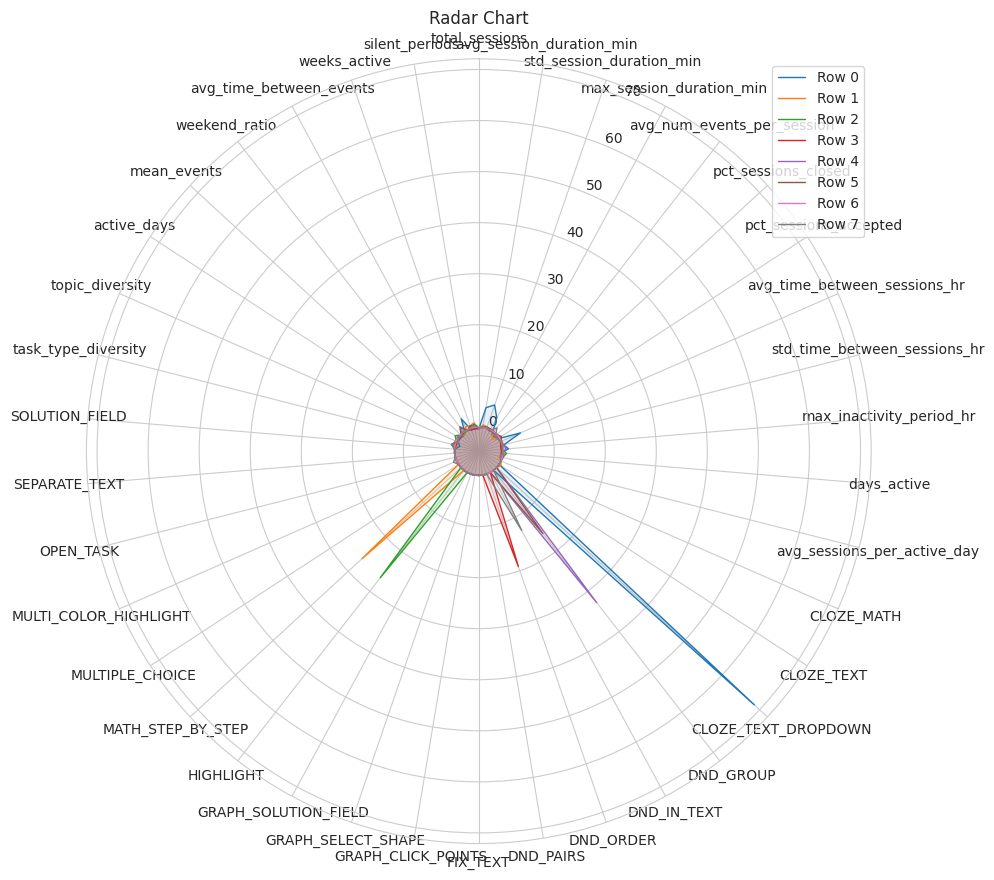

In [125]:
without_preferred_clusters9, without_preferred_clusters_centroids9 = init_fit_hdbscan_clustering(X_without_preferred, min_cluster_size=4, cluster_selection_epsilon=5.0)
create_radar_chart(without_preferred_clusters_centroids9)

In [126]:
without_preferred_clusters9['labels'].value_counts()

labels
 6    18787
-1      125
 3        7
 1        5
 7        5
 0        4
 4        4
 2        4
 5        4
Name: count, dtype: int64

Model fitted. Num of clusters found: 2
Labels and probabilities added


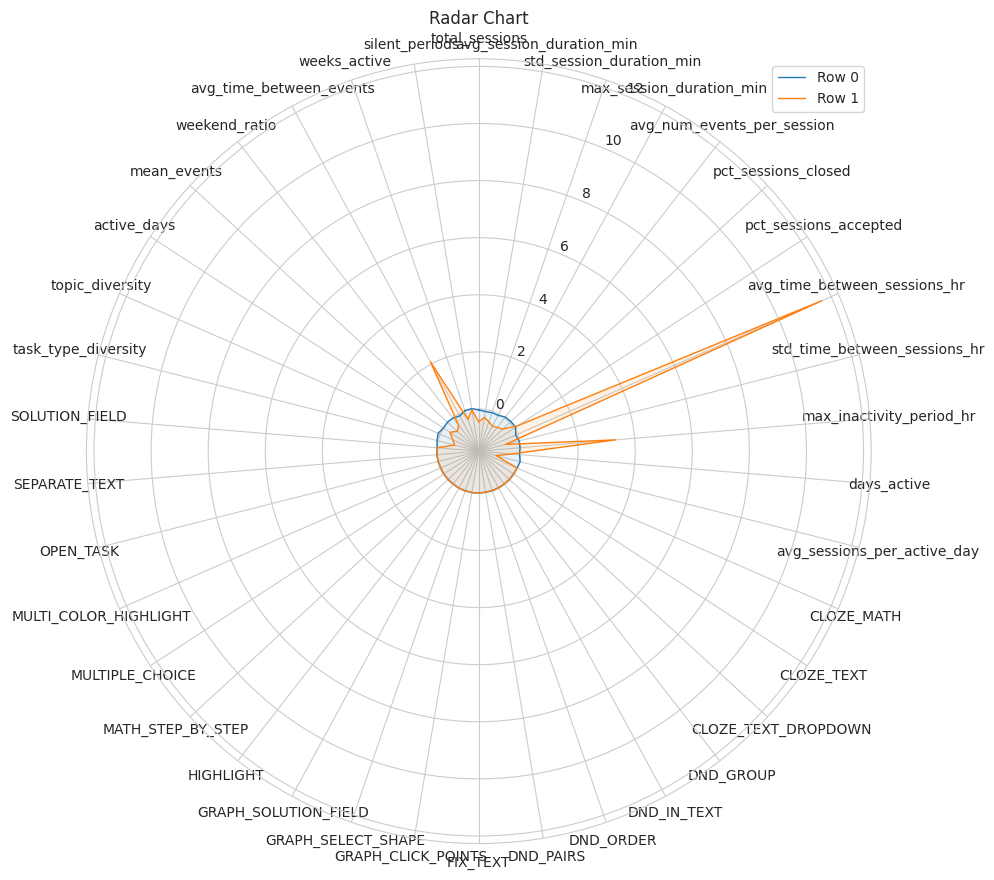

In [127]:
without_preferred_clusters3, without_preferred_clusters3_centroids = init_fit_hdbscan_clustering(X_without_preferred, min_cluster_size=6, cluster_selection_epsilon=5.0)
create_radar_chart(without_preferred_clusters3_centroids)

### For session-based features

In [128]:
session_df = final_session_features.drop(columns=['user_id'])
user_ids_session = final_session_features['user_id']

session_scaled_df = scaler.fit_transform(session_df)
session_scaled_df = pd.DataFrame(session_scaled_df, columns=session_df.columns)


In [129]:
# Initialize the parameters to be tuned
min_cluster_size_list = [10, 20, 30, 40]
cluster_selection_epsilon_list = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]

# Perform hyperparameters tuning for the entire dataset
score_list, nb_clusters_list, nb_outliers_list = run_hdbscan_grid_search(session_scaled_df, min_cluster_size_list, cluster_selection_epsilon_list)

For min_cluster_size=10 and cluster_selection_epsilon=0.0:
	Nb clusters: 153
	Nb outliers: 14976
	Silhouette score: -0.3454760679574085
For min_cluster_size=10 and cluster_selection_epsilon=1.0:
	Nb clusters: 8
	Nb outliers: 2950
	Silhouette score: 0.17673343134326508
For min_cluster_size=10 and cluster_selection_epsilon=2.0:
	Nb clusters: 4
	Nb outliers: 414
	Silhouette score: 0.6640313080693231
For min_cluster_size=10 and cluster_selection_epsilon=3.0:
	Nb clusters: 3
	Nb outliers: 368
	Silhouette score: 0.6983806492394782
For min_cluster_size=10 and cluster_selection_epsilon=4.0:
	Nb clusters: 3
	Nb outliers: 368
	Silhouette score: 0.6983806492394782
For min_cluster_size=10 and cluster_selection_epsilon=5.0:
	Nb clusters: 3
	Nb outliers: 368
	Silhouette score: 0.6983806492394782
-----------------------------------
For min_cluster_size=20 and cluster_selection_epsilon=0.0:
	Nb clusters: 60
	Nb outliers: 14835
	Silhouette score: -0.25979719886359814
For min_cluster_size=20 and cluster

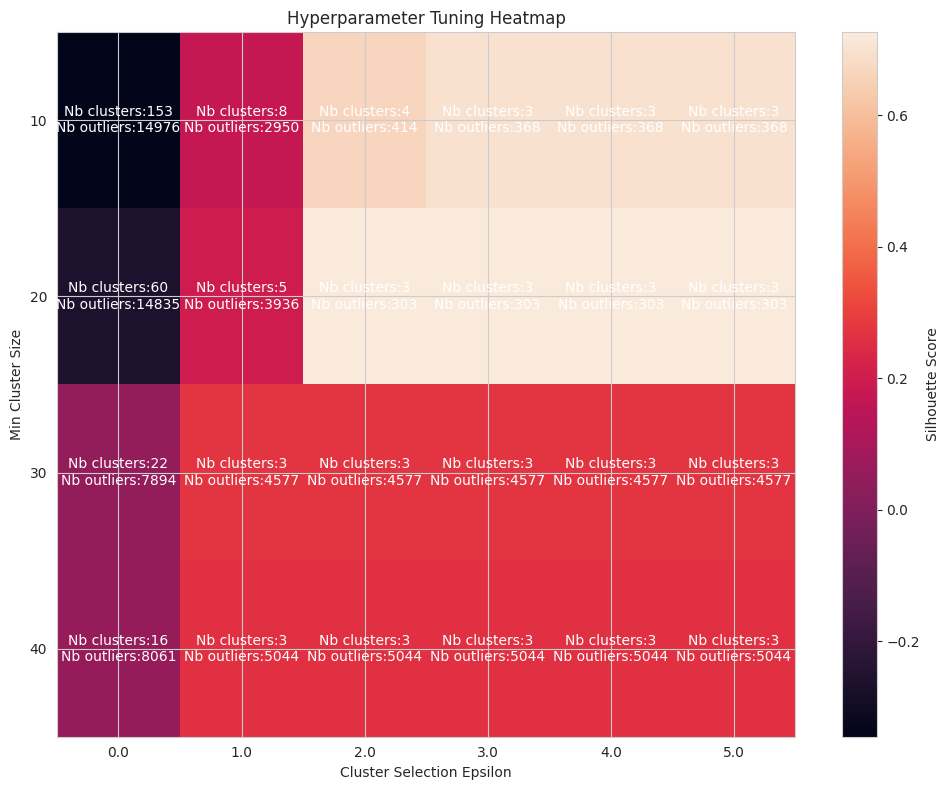

In [130]:
plot_hyperparameter_tuning_heatmap(score_list, min_cluster_size_list, cluster_selection_epsilon_list, nb_clusters_list, nb_outliers_list)

Model fitted. Num of clusters found: 3
Labels and probabilities added


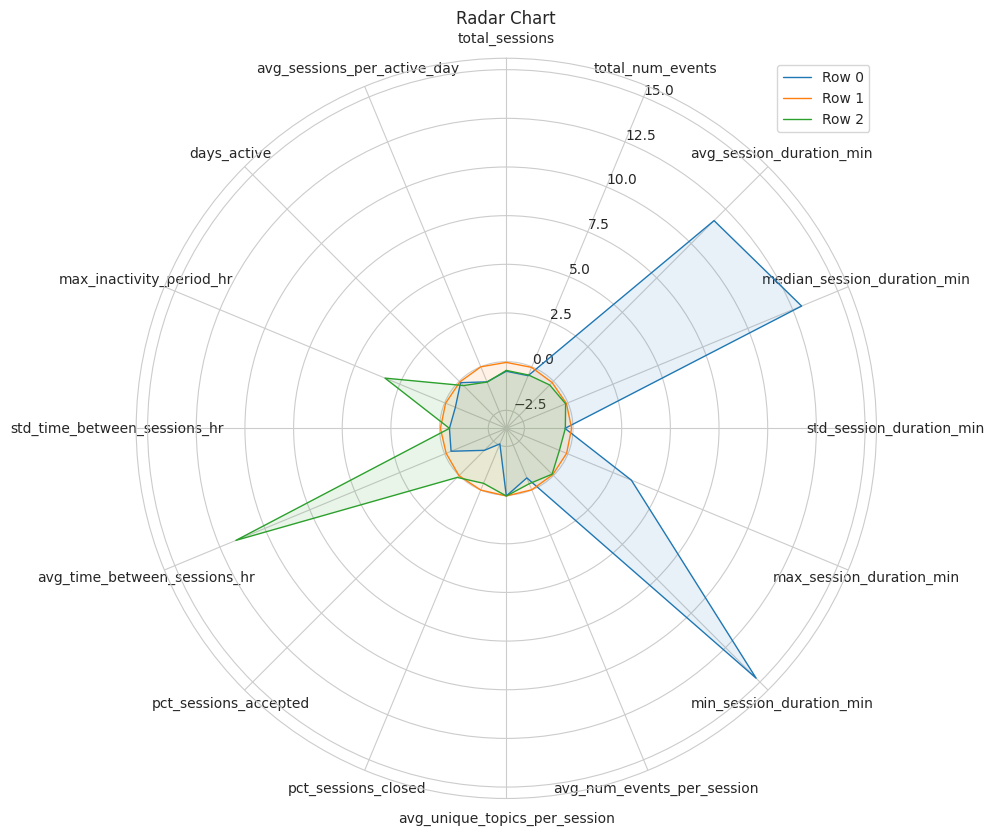

In [133]:
session_clusters5, session_clusters5_centroids = init_fit_hdbscan_clustering(session_scaled_df, min_cluster_size=10, cluster_selection_epsilon=2.0)
create_radar_chart(session_clusters5_centroids)

In [132]:
session_clusters5['labels'].value_counts()


labels
 2    13809
-1     3936
 3     1831
 0       29
 1       25
Name: count, dtype: int64

In [69]:
len(session_scaled_df)

19630

In [70]:
session_scaled_df.head()

,total_sessions,total_num_events,avg_session_duration_min,median_session_duration_min,std_session_duration_min,max_session_duration_min,min_session_duration_min,avg_num_events_per_session,avg_unique_topics_per_session,pct_sessions_closed,pct_sessions_accepted,avg_time_between_sessions_hr,std_time_between_sessions_hr,max_inactivity_period_hr,days_active,avg_sessions_per_active_day
0,2.178260,2.130770,0.040976,-0.148184,1.091944,3.761500,-0.102599,0.114304,-3.186342,0.591600,0.156031,-0.027532,0.017587,0.189341,11.377830,-0.436068
1,2.445658,1.259583,0.468185,-0.148128,1.881149,4.092042,-0.102599,-0.519263,-1.719896,0.598772,0.574557,-0.088120,0.066162,0.865307,5.773261,-0.129748
2,0.841269,0.604393,0.013797,-0.148119,0.529834,1.386367,-0.102599,-0.154392,-17.761478,0.648977,0.574557,0.226730,0.463874,0.832133,9.793930,-0.394132
3,-0.362023,-0.446792,-0.291957,-0.148195,-0.415370,-0.485347,-0.102584,-0.818458,0.045627,-0.154303,0.574557,0.272961,0.168855,-0.102089,-0.196822,-0.727451
4,-0.451156,-0.405992,-0.291734,-0.147948,-0.415368,-0.485275,-0.102306,0.643939,0.045627,0.648977,0.574557,-0.355972,-0.507214,-0.595344,0.656047,-0.475209


In [92]:
clusterer = HDBSCAN(min_cluster_size=20, cluster_selection_epsilon=1.0, store_centers='both')
labels = clusterer.fit(session_scaled_df)

In [93]:
session_scaled_df['labels'] = labels.labels_

In [102]:
medoids = pd.DataFrame(labels.medoids_)
medoids.columns = session_scaled_df.columns
medoids

,total_sessions,total_num_events,avg_session_duration_min,median_session_duration_min,std_session_duration_min,max_session_duration_min,min_session_duration_min,avg_num_events_per_session,avg_unique_topics_per_session,pct_sessions_closed,pct_sessions_accepted,avg_time_between_sessions_hr,std_time_between_sessions_hr,max_inactivity_period_hr,days_active,avg_sessions_per_active_day,labels
0,-0.495722,-0.504391,11.471477,12.778314,-0.415383,3.460523,14.480773,-0.885953,0.045627,-2.564143,-1.831966,-0.356219,-0.507214,-0.595425,-0.074984,-0.853572,0.0
1,-0.317456,-0.261994,0.802516,-0.147906,1.547809,1.176416,-0.102599,0.427954,0.045627,0.006353,-0.628705,0.974867,1.379024,0.909575,-0.196822,-0.758981,-1.0
2,0.261906,0.157999,0.181772,-0.148117,0.851595,1.338854,-0.102597,-0.101009,0.045627,0.470470,-0.388052,0.237889,0.697678,1.056566,0.656047,0.130171,7.0
3,-0.495722,-0.516391,-0.291806,-0.148027,-0.415383,-0.485303,-0.102380,-1.335921,0.045627,-2.564143,0.574557,-0.356219,-0.507214,-0.595425,-0.684176,-0.853572,1.0
4,-0.495722,-0.497191,2.560609,2.986411,-0.415383,0.471499,3.433810,-0.615972,0.045627,-2.564143,-1.831966,-0.356219,-0.507214,-0.595425,-0.318661,-0.853572,4.0
5,-0.228324,-0.269194,-0.217957,-0.148139,-0.238290,-0.311680,-0.102541,-0.166004,0.045627,0.189960,0.574557,-0.235953,-0.253571,-0.359555,-0.074984,0.092335,3.0
6,-0.495722,-0.506791,-0.290325,-0.146400,-0.415383,-0.484806,-0.100544,-0.975947,0.045627,-2.564143,-1.831966,-0.356219,-0.507214,-0.595425,-0.562337,-0.853572,2.0


In [95]:
print(f'Unique clusters: {len(session_scaled_df['labels'].unique())}')

Unique clusters: 8


In [96]:
len(session_scaled_df[session_scaled_df['labels'] == -1])

861

In [97]:
session_scaled_df

,total_sessions,total_num_events,avg_session_duration_min,median_session_duration_min,std_session_duration_min,max_session_duration_min,min_session_duration_min,avg_num_events_per_session,avg_unique_topics_per_session,pct_sessions_closed,pct_sessions_accepted,avg_time_between_sessions_hr,std_time_between_sessions_hr,max_inactivity_period_hr,days_active,avg_sessions_per_active_day,labels
0,2.178260,2.130770,0.040976,-0.148184,1.091944,3.761500,-0.102599,0.114304,-3.186342,0.591600,0.156031,-0.027532,0.017587,0.189341,11.377830,-0.436068,-1
1,2.445658,1.259583,0.468185,-0.148128,1.881149,4.092042,-0.102599,-0.519263,-1.719896,0.598772,0.574557,-0.088120,0.066162,0.865307,5.773261,-0.129748,-1
2,0.841269,0.604393,0.013797,-0.148119,0.529834,1.386367,-0.102599,-0.154392,-17.761478,0.648977,0.574557,0.226730,0.463874,0.832133,9.793930,-0.394132,-1
3,-0.362023,-0.446792,-0.291957,-0.148195,-0.415370,-0.485347,-0.102584,-0.818458,0.045627,-0.154303,0.574557,0.272961,0.168855,-0.102089,-0.196822,-0.727451,5
4,-0.451156,-0.405992,-0.291734,-0.147948,-0.415368,-0.485275,-0.102306,0.643939,0.045627,0.648977,0.574557,-0.355972,-0.507214,-0.595344,0.656047,-0.475209,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19625,-0.362023,-0.470791,-0.291877,-0.148157,-0.415270,-0.485266,-0.102577,-1.043442,0.045627,-0.154303,-1.831966,-0.356098,-0.507101,-0.595336,-0.684176,0.281516,5
19626,-0.495722,-0.504391,-0.291644,-0.147849,-0.415383,-0.485249,-0.102179,-0.885953,0.045627,0.648977,-1.831966,-0.356219,-0.507214,-0.595425,-0.684176,-0.853572,5
19627,-0.451156,-0.461191,-0.291778,-0.147996,-0.415287,-0.485268,-0.102439,-0.390988,0.045627,0.648977,0.574557,-0.356087,-0.507214,-0.595382,-0.684176,-0.475209,5
19628,-0.451156,-0.511591,-0.291968,-0.148206,-0.415368,-0.485353,-0.102596,-1.335921,0.045627,-0.957583,-1.831966,-0.356210,-0.507214,-0.595422,-0.684176,-0.475209,5


In [98]:
evaluate_model(clusterer, session_scaled_df, 2, aggregate=None)

100%|██████████| 2/2 [00:34<00:00, 17.22s/it]


[np.float64(0.33402159713061974), np.float64(0.33402159713061974)]

In [100]:
session_scaled_df.head()

,session_id,num_events_in_session,session_duration_min,session_closed,session_accepted,unique_topics_in_session
0,-1.807509,-0.225930,0.178842,0.235519,0.149435,0.066952
1,-1.612460,-0.399136,12.554827,0.235519,NaN,0.066952
2,-1.601635,-0.976489,-0.158049,0.235519,NaN,0.066952
3,-1.594713,-0.918754,-0.158047,0.235519,NaN,0.066952
4,-1.560331,-0.918754,-0.158046,0.235519,0.149435,0.066952


In [62]:
preferred_labels_df = X_scaled_final_clustering[X_scaled_final_clustering.duplicated(['preferred_task_type_MULTI_COLOR_HIGHLIGHT', 'preferred_task_type_CLOZE_MATH', 'preferred_task_type_CLOZE_TEXT', 'preferred_task_type_CLOZE_TEXT_DROPDOWN', 'preferred_task_type_DND_GROUP', 'preferred_task_type_DND_PAIRS', 'preferred_task_type_HIGHLIGHT', 'preferred_task_type_MATH_STEP_BY_STEP', 'preferred_task_type_MULTIPLE_CHOICE', 'preferred_task_type_SOLUTION_FIELD'], keep=False)].groupby(['preferred_task_type_MULTI_COLOR_HIGHLIGHT', 'preferred_task_type_CLOZE_MATH', 'preferred_task_type_CLOZE_TEXT', 'preferred_task_type_CLOZE_TEXT_DROPDOWN', 'preferred_task_type_DND_GROUP', 'preferred_task_type_DND_PAIRS', 'preferred_task_type_HIGHLIGHT', 'preferred_task_type_MATH_STEP_BY_STEP', 'preferred_task_type_MULTIPLE_CHOICE', 'preferred_task_type_SOLUTION_FIELD'])['labels'].apply(set).reset_index()

In [63]:
preferred_labels_df

,preferred_task_type_MULTI_COLOR_HIGHLIGHT,preferred_task_type_CLOZE_MATH,preferred_task_type_CLOZE_TEXT,preferred_task_type_CLOZE_TEXT_DROPDOWN,preferred_task_type_DND_GROUP,preferred_task_type_DND_PAIRS,preferred_task_type_HIGHLIGHT,preferred_task_type_MATH_STEP_BY_STEP,preferred_task_type_MULTIPLE_CHOICE,preferred_task_type_SOLUTION_FIELD,labels
0,-0.140513,-0.231470,-0.481129,-0.536750,-0.104833,-0.137550,-0.136134,-0.206670,-0.747023,-0.219123,"{12, 13, 14, 15, -1}"
1,-0.140513,-0.231470,-0.481129,-0.536750,-0.104833,-0.137550,-0.136134,-0.206670,-0.747023,4.563648,"{8, -1}"
2,-0.140513,-0.231470,-0.481129,-0.536750,-0.104833,-0.137550,-0.136134,-0.206670,1.338647,-0.219123,"{32, 33, 34, 30, 25, 26, 27, 28, 29, -1, 31}"
3,-0.140513,-0.231470,-0.481129,-0.536750,-0.104833,-0.137550,-0.136134,4.838626,-0.747023,-0.219123,"{-1, 7}"
4,-0.140513,-0.231470,-0.481129,-0.536750,-0.104833,-0.137550,7.345677,-0.206670,-0.747023,-0.219123,"{1, -1}"
5,-0.140513,-0.231470,-0.481129,-0.536750,-0.104833,7.270094,-0.136134,-0.206670,-0.747023,-0.219123,"{3, 4, 5, 6, -1}"
6,-0.140513,-0.231470,-0.481129,-0.536750,9.538942,-0.137550,-0.136134,-0.206670,-0.747023,-0.219123,"{0, -1}"
7,-0.140513,-0.231470,-0.481129,1.863063,-0.104833,-0.137550,-0.136134,-0.206670,-0.747023,-0.219123,"{10, 16, 21, 22, 23, 24, -1}"
8,-0.140513,-0.231470,2.078444,-0.536750,-0.104833,-0.137550,-0.136134,-0.206670,-0.747023,-0.219123,"{11, 17, 18, 19, 20, -1}"
9,-0.140513,4.320211,-0.481129,-0.536750,-0.104833,-0.137550,-0.136134,-0.206670,-0.747023,-0.219123,"{9, -1}"


In [64]:
X_scaled_final_clustering['labels'].unique()

array([-1,  7,  9,  0, 17, 13,  4, 30, 21,  2, 26,  3,  1,  8, 31, 22, 34,
       12, 32, 23, 15, 28,  5, 20,  6, 18, 19, 25, 24, 14, 27, 10, 11, 33,
       29, 16])

*Your discussion about your model training goes here*

## Task 3: Model Evaluation
In this task, you will use metrics to evaluate your model.

In [65]:
kmeans = KMeans(n_clusters=30, n_init="auto")

evaluate_model(kmeans, X_scaled_final_clustering, 5, aggregate=None)

100%|██████████| 5/5 [00:26<00:00,  5.28s/it]


[np.float64(0.30840310546349564),
 np.float64(0.3103990589955033),
 np.float64(0.3069018385981485),
 np.float64(0.30120197259487225),
 np.float64(0.2751028622235453)]

In [66]:
# Your code for model evaluation goes here
evaluate_model(clusterer, X_scaled_final_clustering, 5, aggregate=None)

100%|██████████| 5/5 [02:38<00:00, 31.75s/it]


[np.float64(0.35011821664142595),
 np.float64(0.35011821664142595),
 np.float64(0.35011821664142595),
 np.float64(0.35011821664142595),
 np.float64(0.35011821664142595)]

*Your discussion/interpretation about your model's behavior goes here*

## Task 4: Team Reflection
Please describe the contributions of each team member to Milestone 4. Reflect on how you worked as team: what went well, what can be improved for the next milestone?

*Your discussion about team responsibilities goes here*